In [44]:
#Python/Data
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors
import numpy as np
import h5py as h5
import uproot3 as ur
import awkward as ak
from data_functions import *
from matplotlib import style
#style.use('/global/home/users/ftoralesacosta/dotfiles/scientific.mplstyle')

import os
import shutil

#ML
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split
import tensorflow as tf
GeV_to_MeV=1000

## File Names and Output Directory

In [45]:
#filename = "2M_uncompressed.hdf5"
#h5_filename = "../generate_data/to_hdf5/Ecut_GeV.hdf5"
#ROOT_file = "../generate_data/to_hdf5/2M_piplus.root"

cut_choices=["nocut","hitscut1","cut1N2"]
choice=2
file_path="/media/miguel/Elements/Data_hcali/Data1"
ROOT_file = f"{file_path}/Uniform_pi+_0-100GeV_standalone.root"
#h5_filename =f"{file_path}/pi+_495k_0_100GeV_train_split.hdf5"
h5_filename=f"{file_path}/Uniform_pi+_0-100GeV_standalone_full_{cut_choices[choice]}.hdf5"


#h5_filename = "../generate_data/to_hdf5/Uniform_pi+_0-100GeV_NO_CELL_CUTS.hdf5"

working_dir="/home/bishnu/EIC"
new_dir="output_reg_dnn_straw_comp"
try:
    os.makedirs(f"{working_dir}/{new_dir}",exist_ok=True)
except OSError:
    print("Directory creation Error "%new_dir)
else:
    print("Directory %s is created"%new_dir)
output_path=f"{working_dir}/{new_dir}"





#label = "train_split_dnn"  #Replace with your own variation!      
#path = "./"+label

#shutil.rmtree(path, ignore_errors=True)
#os.makedirs(path)
print(h5_filename)

Directory output_reg_dnn_straw_comp is created
/media/miguel/Elements/Data_hcali/Data1/Uniform_pi+_0-100GeV_standalone_full_cut1N2.hdf5


## Data Cuts

In [47]:
N_Events = 100_000

cut_on_clusters = True
cut_on_genTheta = False
cut_on_genP = False #True for Debug only

min_theta = 5.0 #5 for HCAL
max_theta = 30.0

hit_e_max = 1e10 #Spikes...
hit_e_min = 0.00006 #MIPs
hit_t_max = 200

min_cluster_E = 0.22 #GeV
#min_cluster_E = 0.0 #GeV

#sampling_fraction = 0.02 #HCAL
hcali_sampling_fraction = 0.0098 #INSERT
hcal_sampling_fraction=0.02


## Model Settings

In [48]:
learning_rate = 1e-4
dropout_rate = 0.05
batch_size = 1000
N_Epochs = 400
patience = 20
N_Latent = 128
shuffle_split = False #Turn FALSE for images!
train_shuffle = False #False for better root hf comparison
Y_scalar = True
loss = 'mse'
#loss = tf.keras.losses.MeanAbsoluteError()

## I/O

In [49]:
h5_file = h5.File(h5_filename,'r')
print(list(h5_file.keys()))


ur_file = ur.open( ROOT_file )
ur_tree = ur_file['events']



['hcal', 'hcali', 'mc']


#### Get HDF5 E hits and Gen P

In [50]:
h5_detector = 'hcali'
h5_gen_P = h5_file['mc'][:N_Events,8,0]
h5_gen_Theta = h5_file['mc'][:N_Events,9,0]
h5_hits_e = h5_file[h5_detector][:N_Events,0]
h5_hits_e_hcal = h5_file['hcal'][:N_Events,0]


#### Get ROOT E hits and Gen P

In [52]:
root_detector_hcal = "HcalEndcapPHitsReco"
root_detector = "HcalEndcapPInsertHitsReco"

genPx = ur_tree.array('MCParticles.momentum.x',entrystop=N_Events)[:,2]
genPy = ur_tree.array('MCParticles.momentum.y',entrystop=N_Events)[:,2]
genPz = ur_tree.array('MCParticles.momentum.z',entrystop=N_Events)[:,2]
root_gen_P = np.sqrt(genPx*genPx + genPy*genPy + genPz*genPz)
root_gen_Theta = np.arccos(genPz/root_gen_P)*180/np.pi

root_hits_e = ur_tree.array('%s.energy' % root_detector, entrystop=N_Events)
root_hits_e_hcal = ur_tree.array('%s.energy' % root_detector_hcal, entrystop=N_Events)

root_hits_t = ur_tree.array('%s.time' % root_detector, entrystop=N_Events)

ROOT needs to have cuts applied here. HDF5 File should already have them applied

In [8]:
#plt.hist(h5_hits_e,bins=100,range=(0.1,100),label='hdf5')
#plt.hist(root_hits_e,bins=100,range=(0,10),label='root')


#plt.hist(root_hits_e)
#root_cuts = np.ones(len(root_hits_e))
#root_cuts = root_hits_e > hit_e_min                                                                   
#root_cuts = np.logical_and( root_cuts, root_hits_t <= hit_t_max )  
#root_cuts = np.logical_and( root_cuts, root_hits_e > hit_e_min )                                     



#root_hits_e = root_hits_e[root_cuts]

#### Apply HDF5 cuts just in case 

In [9]:
#h5_cuts = h5_hits_e >hit_e_min
#h5_cuts = np.logical_and( h5_cuts, h5_hits_e <= hit_e_max )
#h5_cuts = np.logical_and( h5_cuts, h5_hits_e <= hit_t_max )
#h5_cuts=h5_hits_e <=hit_e_max

In [51]:
#from data_functions import make_comparison_plots

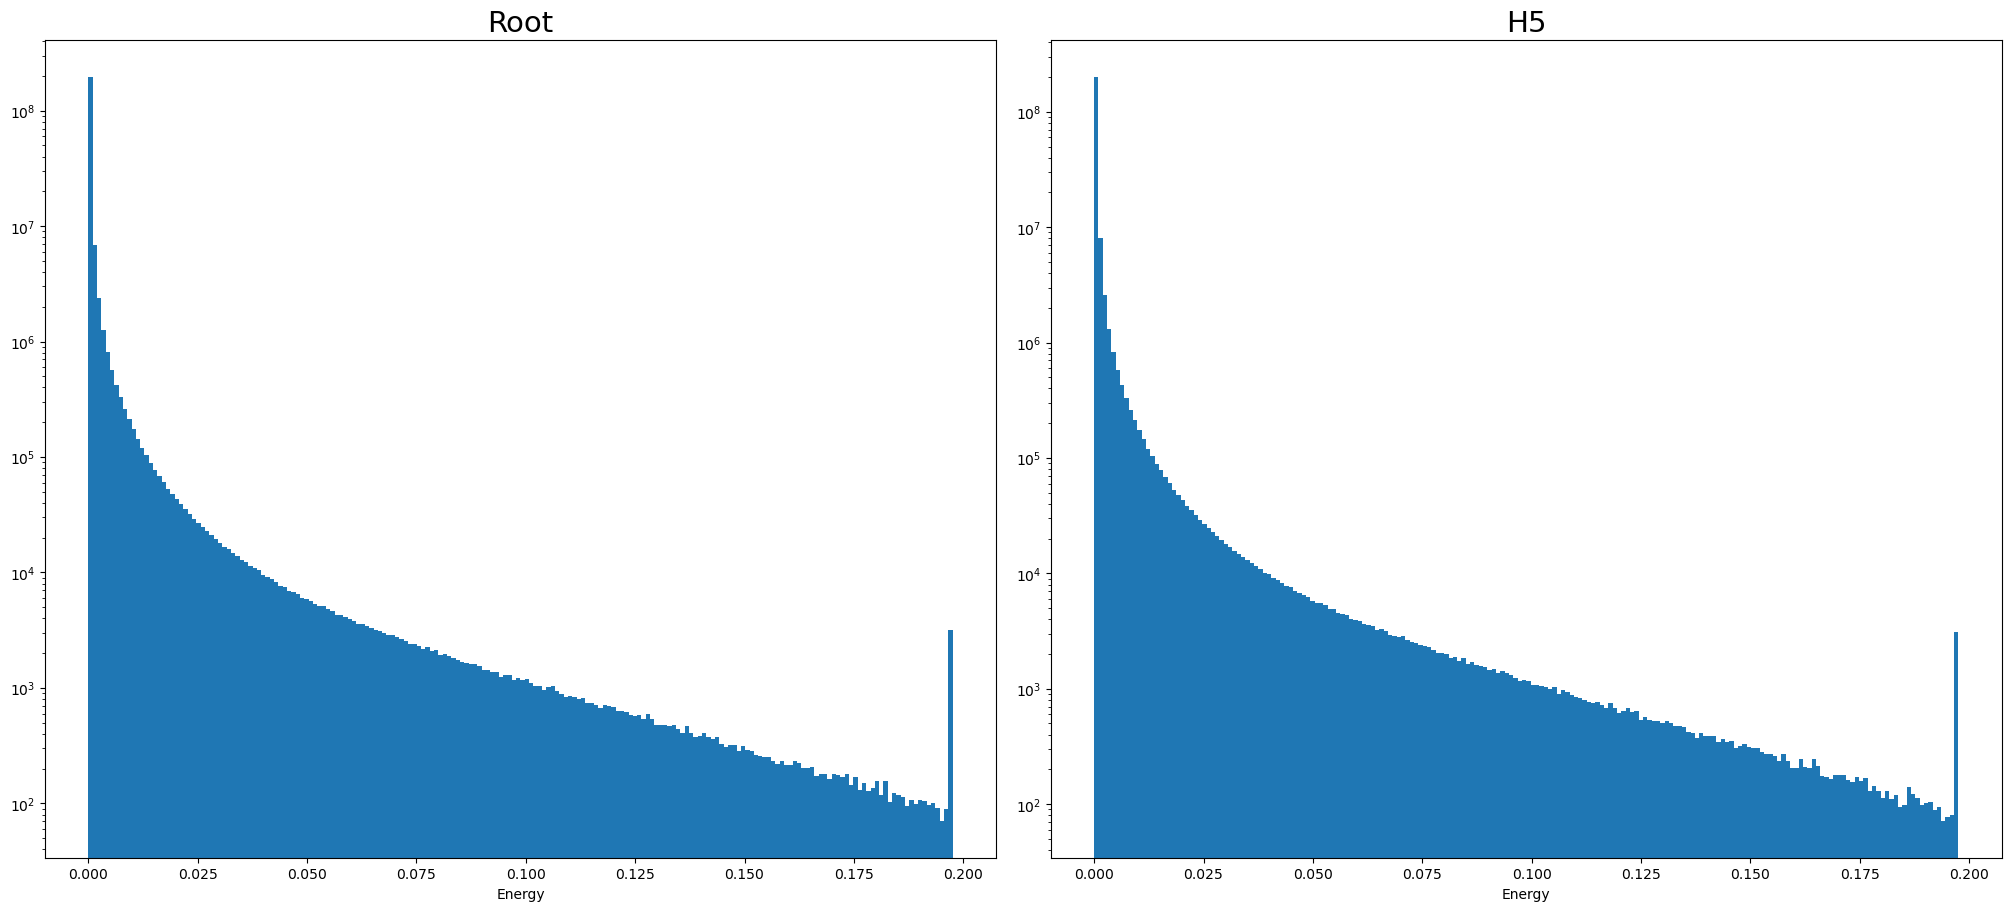

  array length:  200
   0  :  196099397  200876572  Rectangle(xy=(-5.82077e-11, 0), width=0.000987793, height=1.96099e+08, angle=0) *** -4777175
   1  :    6869666    8004296  Rectangle(xy=(0.000987793, 0), width=0.000987793, height=6.86967e+06, angle=0) *** -1134630
   2  :    2392729    2584771  Rectangle(xy=(0.00197559, 0), width=0.000987793, height=2.39273e+06, angle=0) *** -192042
   3  :    1270258    1313398  Rectangle(xy=(0.00296338, 0), width=0.000987793, height=1.27026e+06, angle=0) *** -43140
   4  :     810144     823656  Rectangle(xy=(0.00395117, 0), width=0.000987793, height=810144, angle=0) *** -13512
   5  :     569028     575339  Rectangle(xy=(0.00493896, 0), width=0.000987793, height=569028, angle=0) *** -6311
   6  :     421653     424671  Rectangle(xy=(0.00592676, 0), width=0.000987793, height=421653, angle=0) *** -3018
   7  :     327853     329103  Rectangle(xy=(0.00691455, 0), width=0.000987793, height=327853, angle=0) *** -1250
   8  :     261259     261922  Rec

In [11]:
#make_comparison_plots( root_hits_e, h5_hits_e, 'Energy' )

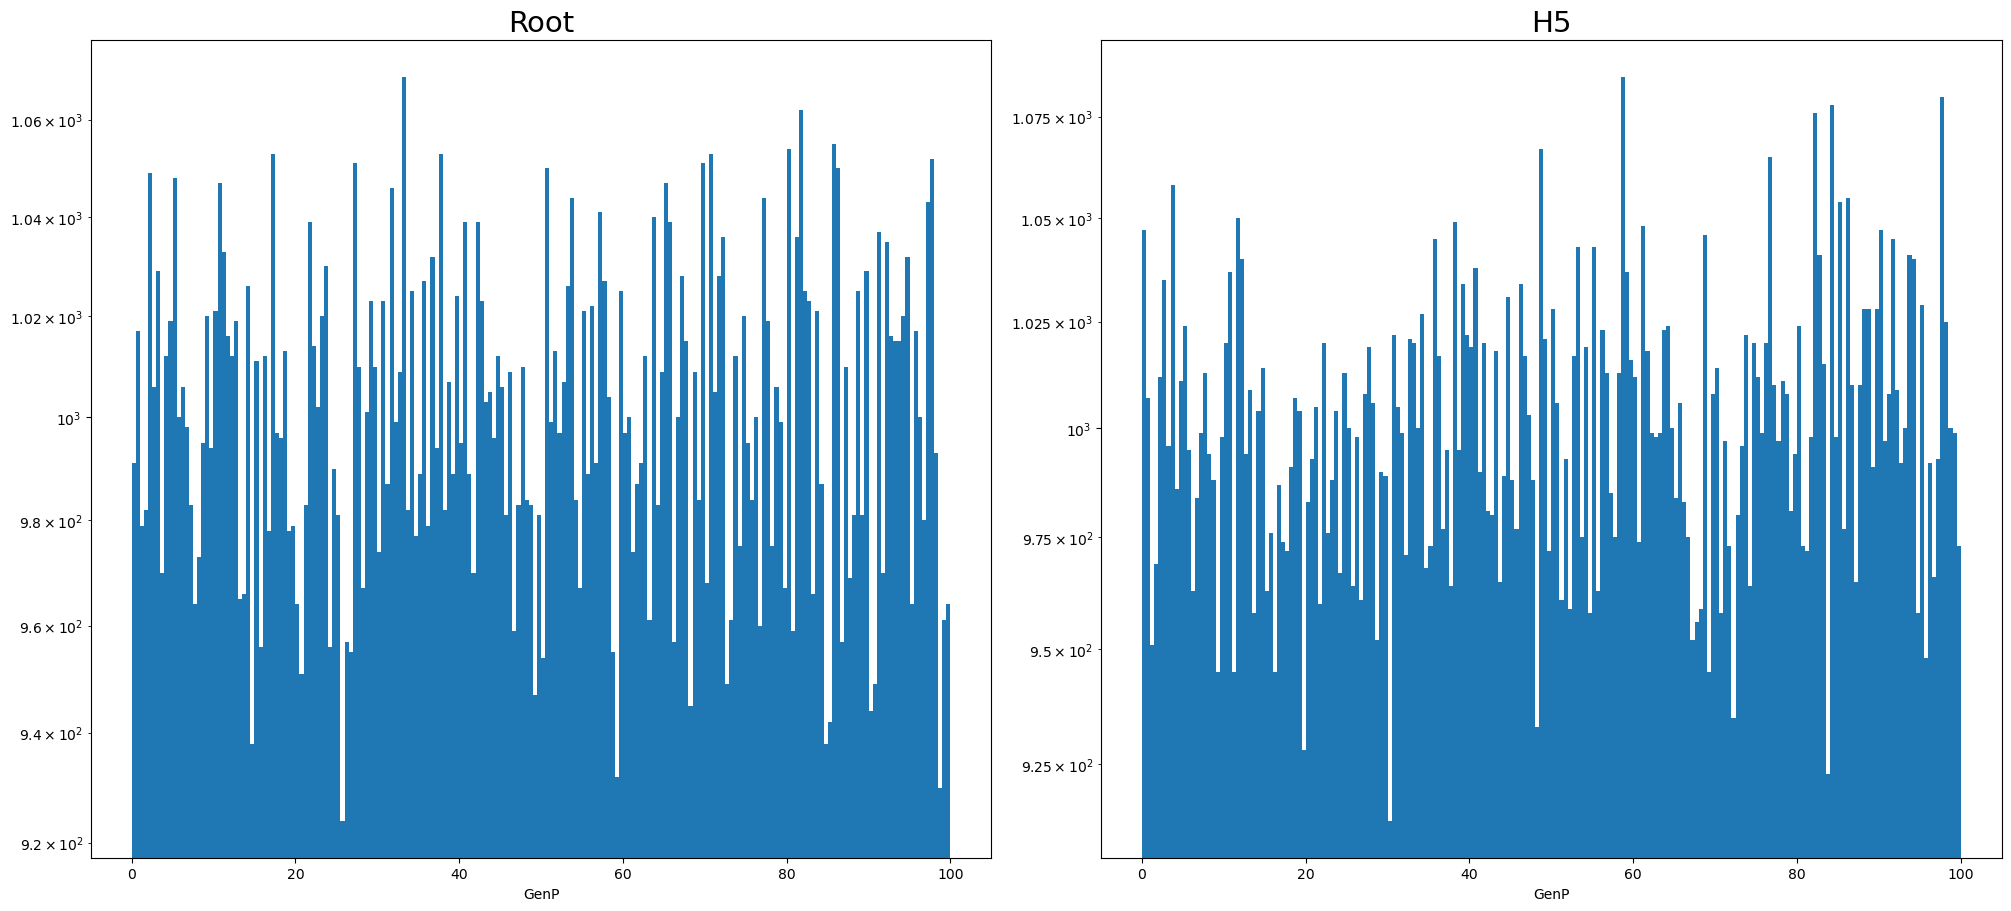

  array length:  200
   0  :        991       1047  Rectangle(xy=(0.00015831, 0), width=0.499998, height=991, angle=0) *** -56
   1  :       1017       1007  Rectangle(xy=(0.500157, 0), width=0.499998, height=1017, angle=0) *** 10
   2  :        979        951  Rectangle(xy=(1.00016, 0), width=0.499998, height=979, angle=0) *** 28
   3  :        982        969  Rectangle(xy=(1.50015, 0), width=0.499998, height=982, angle=0) *** 13
   4  :       1049       1012  Rectangle(xy=(2.00015, 0), width=0.499998, height=1049, angle=0) *** 37
   5  :       1006       1035  Rectangle(xy=(2.50015, 0), width=0.499999, height=1006, angle=0) *** -29
   6  :       1029        996  Rectangle(xy=(3.00015, 0), width=0.499998, height=1029, angle=0) *** 33
   7  :        970       1058  Rectangle(xy=(3.50015, 0), width=0.499999, height=970, angle=0) *** -88
   8  :       1012        986  Rectangle(xy=(4.00015, 0), width=0.499999, height=1012, angle=0) *** 26
   9  :       1019       1011  Rectangle(xy=(4.50

In [12]:
make_comparison_plots( root_gen_P, h5_gen_P, 'GenP' )

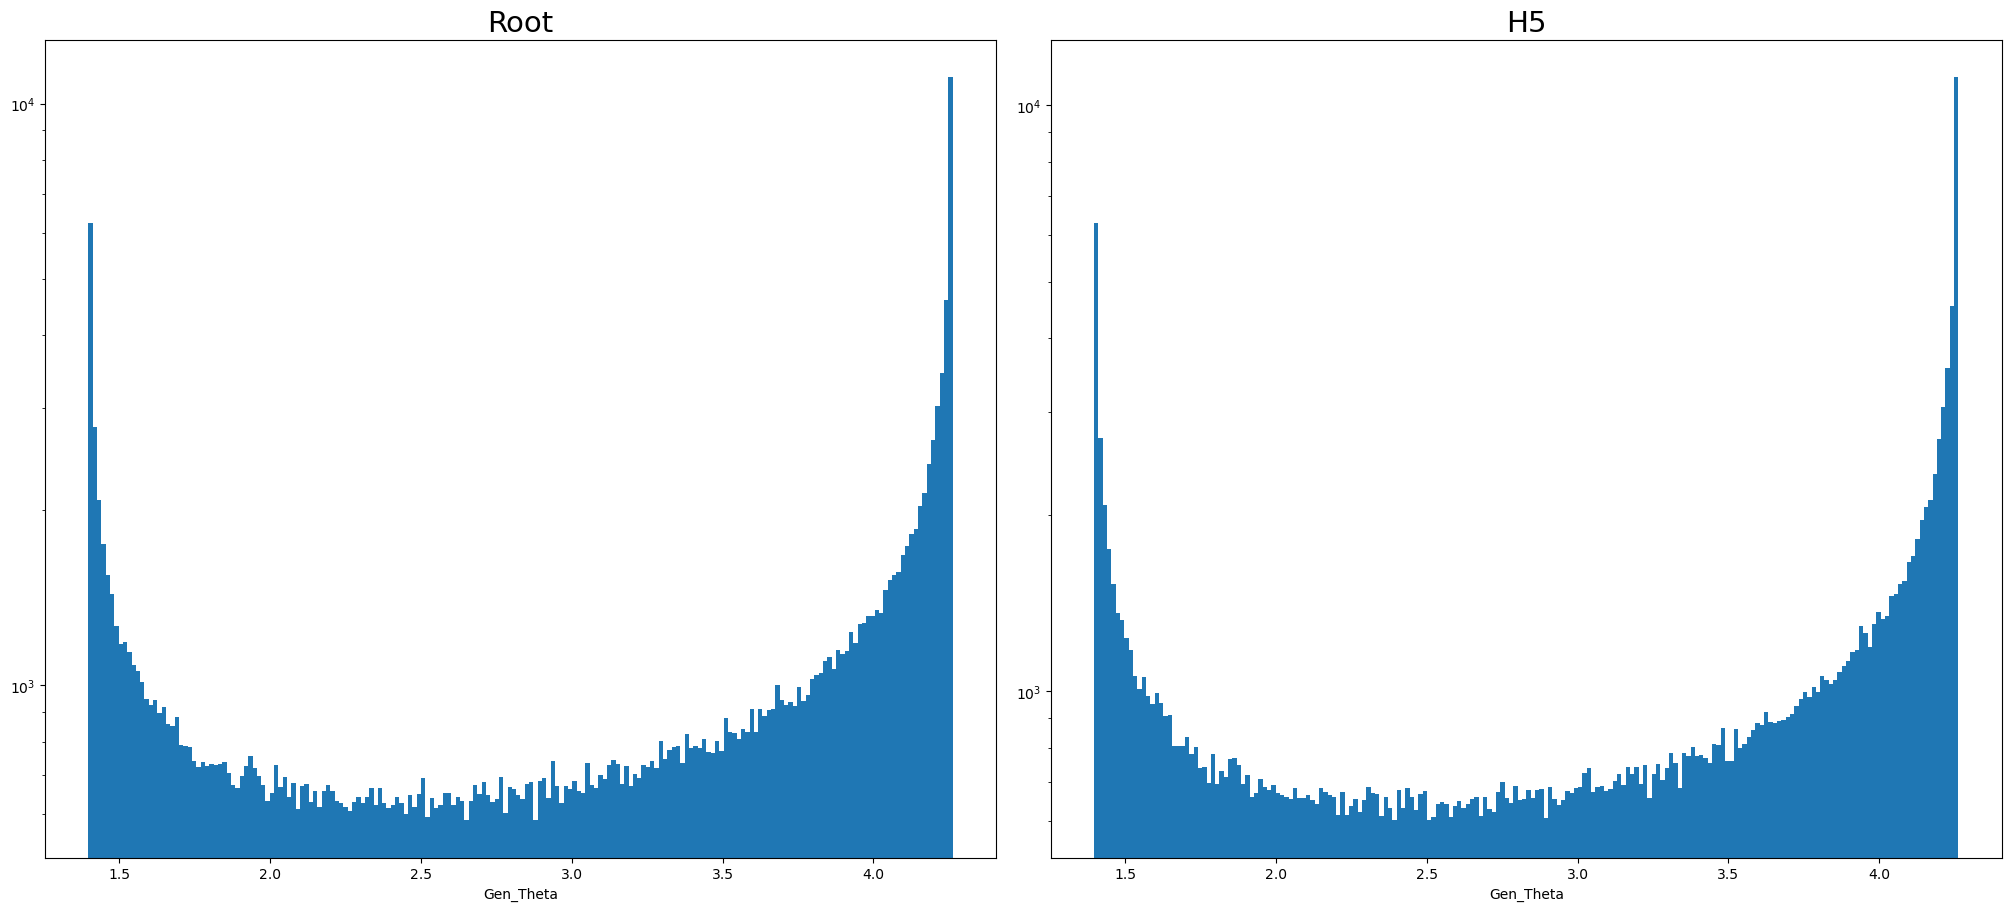

  array length:  200
   0  :       6242       6291  Rectangle(xy=(1.39746, 0), width=0.014325, height=6242, angle=0) *** -49
   1  :       2782       2701  Rectangle(xy=(1.41178, 0), width=0.014325, height=2782, angle=0) *** 81
   2  :       2080       2079  Rectangle(xy=(1.42611, 0), width=0.014325, height=2080, angle=0) *** 1
   4  :       1547       1526  Rectangle(xy=(1.45476, 0), width=0.014325, height=1547, angle=0) *** 21
   5  :       1434       1362  Rectangle(xy=(1.46908, 0), width=0.014325, height=1434, angle=0) *** 72
   6  :       1267       1323  Rectangle(xy=(1.48341, 0), width=0.014325, height=1267, angle=0) *** -56
   7  :       1180       1231  Rectangle(xy=(1.49773, 0), width=0.014325, height=1180, angle=0) *** -51
   8  :       1189       1174  Rectangle(xy=(1.51206, 0), width=0.014325, height=1189, angle=0) *** 15
   9  :       1139       1063  Rectangle(xy=(1.52638, 0), width=0.0143249, height=1139, angle=0) *** 76
  10  :       1086       1008  Rectangle(xy=(1.54

In [13]:
make_comparison_plots( root_gen_Theta, h5_gen_Theta, 'Gen_Theta' )

In [14]:
print(root_gen_Theta[:6])
print(h5_gen_Theta[:6])

[3.1682353 3.413575  3.509001  3.8320074 4.2473154 4.1916637]
[2.4868755 4.2380834 3.6431978 2.0569983 1.4812089 3.2622483]


# Cluster Sum

In [53]:
root_cluster_hcali_raw = ak.sum(root_hits_e,axis=-1)
root_cluster_sum_hcali_temp = ak.to_numpy(root_cluster_hcali_raw)
root_cluster_sum_hcali=np.divide(root_cluster_sum_hcali_temp,hcali_sampling_fraction)



hdf5_cluster_hcali_raw = np.nansum(h5_hits_e,axis=-1)
#hdf5_cluster_sum_hcali_temp = ak.to_numpy(hdf5_cluster_hcali_raw)
hdf5_cluster_sum_hcali=np.divide(hdf5_cluster_hcali_raw,hcali_sampling_fraction)


'''
root_cluster_hcal_raw = ak.sum(root_hits_e_hcal,axis=-1)
root_cluster_sum_hcal_temp = ak.to_numpy(root_cluster_hcal_raw)
root_cluster_sum_hcal=np.divide(root_cluster_sum_hcal_temp,hcal_sampling_fraction)

hdf5_cluster_hcal_raw = ak.sum(h5_hits_e_hcal,axis=-1)
hdf5_cluster_sum_hcal_temp = ak.to_numpy(hdf5_cluster_hcal_raw)
hdf5_cluster_sum_hcal=np.divide(hdf5_cluster_sum_hcal_temp,hcal_sampling_fraction)



'''


'\nroot_cluster_hcal_raw = ak.sum(root_hits_e_hcal,axis=-1)\nroot_cluster_sum_hcal_temp = ak.to_numpy(root_cluster_hcal_raw)\nroot_cluster_sum_hcal=np.divide(root_cluster_sum_hcal_temp,hcal_sampling_fraction)\n\nhdf5_cluster_hcal_raw = ak.sum(h5_hits_e_hcal,axis=-1)\nhdf5_cluster_sum_hcal_temp = ak.to_numpy(hdf5_cluster_hcal_raw)\nhdf5_cluster_sum_hcal=np.divide(hdf5_cluster_sum_hcal_temp,hcal_sampling_fraction)\n\n\n\n'

In [16]:
#plt.hist(hdf5_cluster_hcali_raw)

## Apply Sampling Fraction (Make sure it's for HCal or Hcal insert!!)

In [17]:
total_sum=False
if total_sum:
    root_cluster_sum=np.add(root_cluster_sum_hcali,root_cluster_sum_hcal)
    hdf5_cluster_sum=np.add(hdf5_cluster_sum_hcali,hdf5_cluster_sum_hcal)
    
else:
    root_cluster_sum=root_cluster_sum_hcali
    hdf5_cluster_sum=hdf5_cluster_sum_hcali
    
#root_cluster_sum = (root_cluster_sum)
#hdf5_cluster_sum = hdf5_cluster_sum_raw

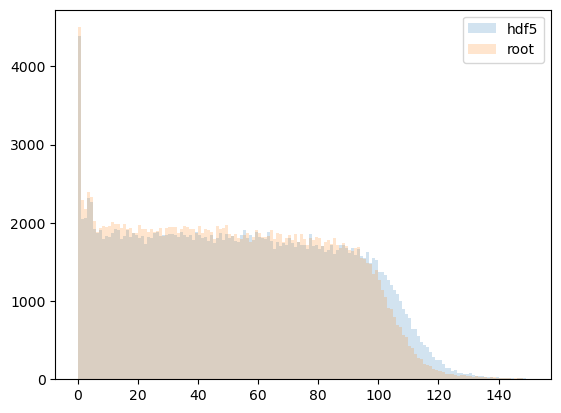

In [18]:
plt.hist(hdf5_cluster_sum,label='hdf5',alpha=0.2, range=(0,150), bins=150)
plt.hist(root_cluster_sum,label='root',alpha=0.2, range=(0,150), bins=150)
plt.legend()

(0.0, 120.0)

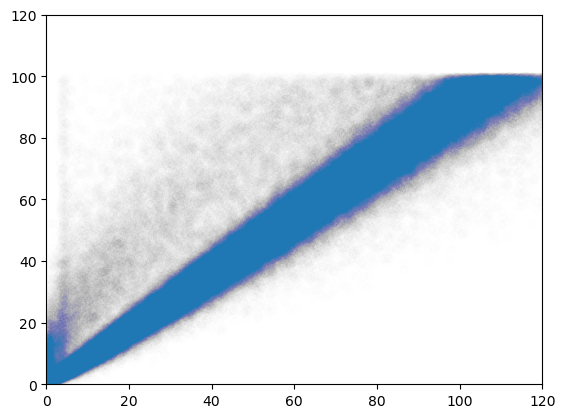

In [19]:
plt.scatter(hdf5_cluster_sum,h5_gen_P,alpha=0.005)  

#plt.scatter(root_cluster_sum,root_gen_P,alpha=0.05)
plt.xlim(0,120)
plt.ylim(0,120)

# Cut on Clusters

In [20]:
#cluster_mask = root_cluster_sum > min_cluster_E
if (cut_on_genP):
    cluster_mask = np.logical_and(cluster_mask, root_gen_P > 20.)
if (cut_on_clusters):
    root_cluster_sum = root_cluster_sum[cluster_mask]
    hdf5_cluster_sum = hdf5_cluster_sum[cluster_mask]
    root_gen_P = root_gen_P[cluster_mask]
    root_gen_Theta = root_gen_Theta[cluster_mask]
    h5_gen_P = h5_gen_P[cluster_mask]
    h5_gen_Theta = h5_gen_Theta[cluster_mask]

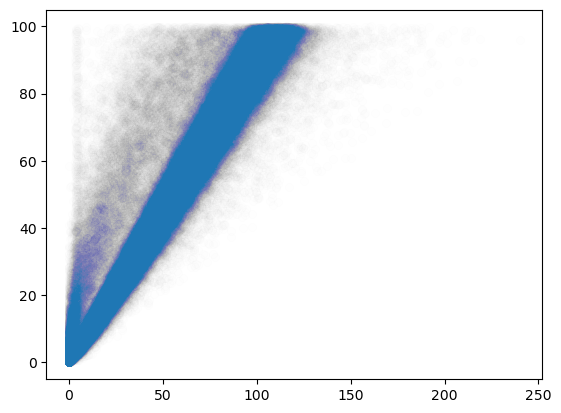

In [21]:
#theta_mask = root_gen_Theta > min_theta
#theta_mask = np.logical_and(root_gen_Theta < max_theta,theta_mask)

if (cut_on_genTheta):
    root_cluster_sum = root_cluster_sum[theta_mask]
    hdf5_cluster_sum = hdf5_cluster_sum[theta_mask]
    root_gen_P = root_gen_P[theta_mask]
    root_gen_Theta = root_gen_Theta[theta_mask]
    h5_gen_P = h5_gen_P[theta_mask]
    h5_gen_Theta = h5_gen_Theta[theta_mask]
    
plt.scatter(hdf5_cluster_sum,h5_gen_P,alpha=0.005)  
#plt.scatter(root_cluster_sum,root_gen_P,alpha=0.005, range=([0,150], [0,150]))

## Cluster Sum and Truth P Correlation

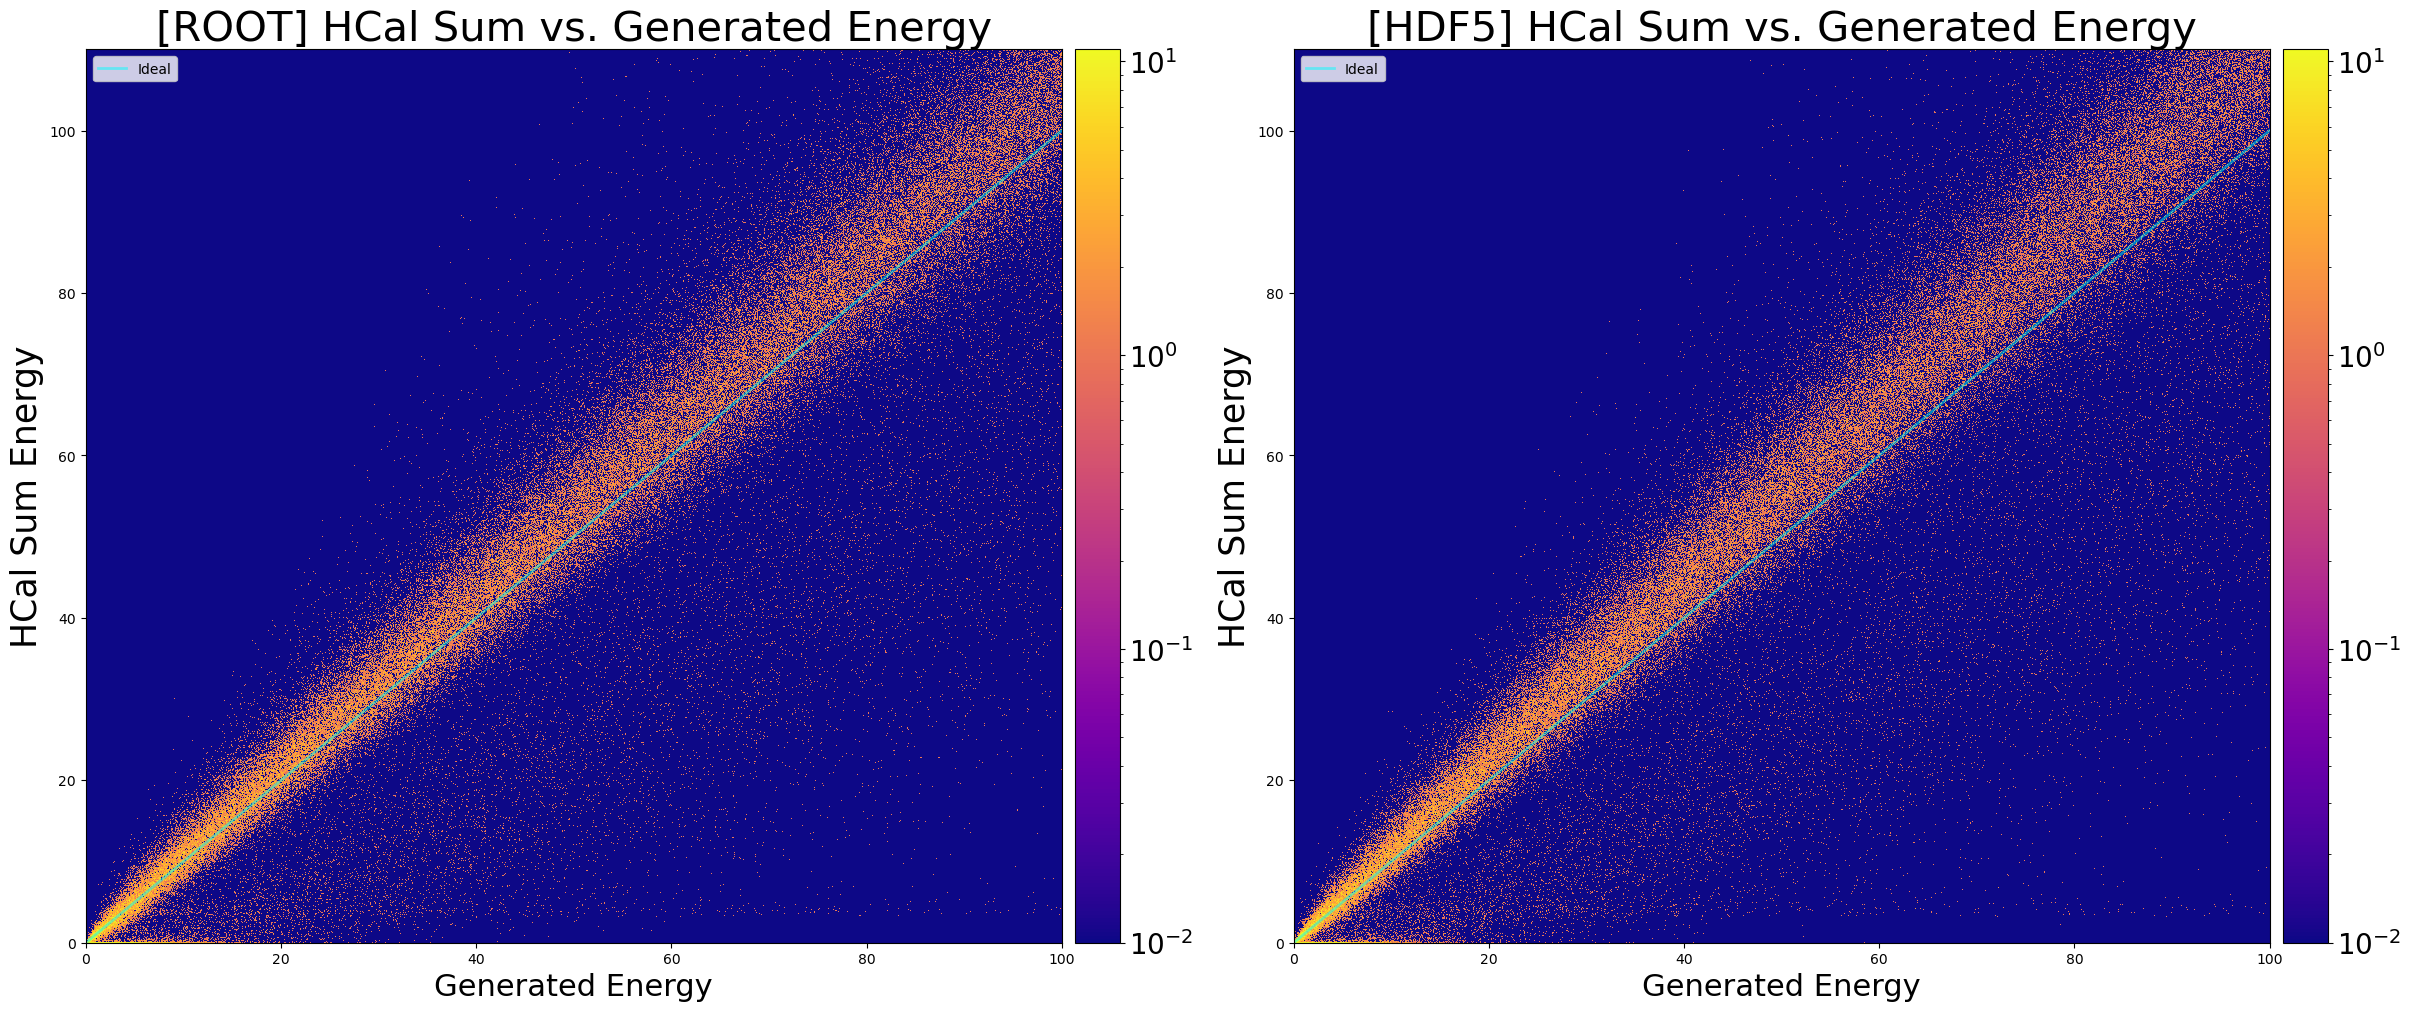

In [22]:
from copy import copy
from matplotlib.colors import LogNorm
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 10), constrained_layout=True)
axes = axes.ravel()
cmap = copy(plt.cm.plasma)
cmap.set_bad(cmap(0))

cluster_edges=np.linspace(0,110,1201)
truth_edges=np.linspace(0,100,1201)


#ROOT
h, xedges, yedges = np.histogram2d(root_gen_P, root_cluster_sum, bins=[truth_edges, cluster_edges])
pcm = axes[0].pcolormesh(xedges, yedges, h.T, cmap=cmap, norm=LogNorm(vmin=1.0e-2,vmax=1.1e1), rasterized=True)
cb = fig.colorbar(pcm, ax=axes[0], pad=0)
cb.ax.tick_params(labelsize=20)
axes[0].set_xlabel("Generated Energy",fontsize=22)
axes[0].set_ylabel("HCal Sum Energy",fontsize=25)
axes[0].set_title("[ROOT] HCal Sum vs. Generated Energy",fontsize=30)
axes[0].plot([0, 100], [0, 100], color="cyan",linewidth=2,alpha=0.5,label="Ideal")
axes[0].legend(loc="upper left")

#HDF5
h, xedges, yedges = np.histogram2d(h5_gen_P, hdf5_cluster_sum, bins=[truth_edges, cluster_edges])
pcm = axes[1].pcolormesh(xedges, yedges, h.T, cmap=cmap, norm=LogNorm(vmin=1.0e-2,vmax=1.1e1), rasterized=True)
cb = fig.colorbar(pcm, ax=axes[1], pad=0)
cb.ax.tick_params(labelsize=20)
axes[1].set_xlabel("Generated Energy",fontsize=22)
axes[1].set_ylabel("HCal Sum Energy",fontsize=25)
axes[1].set_title("[HDF5] HCal Sum vs. Generated Energy",fontsize=30)
axes[1].plot([0, 100], [0, 100], color="cyan",linewidth=2,alpha=0.5,label="Ideal")
axes[1].legend(loc="upper left")



In [23]:
#make_comparison_plots( root_cluster_sum, hdf5_cluster_sum, 'Cluster Sum' )

# At this point, it should be established that ROOT and HDF5 data are IDENTICAL

## Last check: Train on HDF5 and ROOT

In [24]:
h5_X = hdf5_cluster_sum
h5_Y = h5_gen_P

R_X = root_cluster_sum
R_Y = root_gen_P


In [25]:
(h5_X_train, h5_X_val, h5_X_test,
h5_Y_train, h5_Y_val, h5_Y_test) = data_split(h5_X, h5_Y, val=0.2, test=0.3,shuffle=shuffle_split)

(R_X_train, R_X_val, R_X_test,
R_Y_train, R_Y_val, R_Y_test) = data_split(R_X, R_Y, val=0.2, test=0.3,shuffle=shuffle_split)


In [26]:
def step_decay(epoch, lr):
    min_rate = 1.01e-7
    N_start = 10
    N_epochs = 5
    
    return lr
    
    if epoch >= N_start and lr >= min_rate:
        if (epoch%N_epochs==0):
            return lr * 0.1
    return lr

lr_decay = tf.keras.callbacks.LearningRateScheduler(step_decay,verbose=0)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience)

In [27]:
#from tensorflow.keras.layers import Input
h5_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[1]),
    tf.keras.layers.Dense(64, activation='relu'), # 1st hiddden layer
    tf.keras.layers.Dense(64, activation='relu'), # 2nd hiddden layer
    tf.keras.layers.Dense(64, activation='relu'), # 3rd hiddden layer
    tf.keras.layers.Dense(64, activation='relu'), # 4th hiddden layer
    tf.keras.layers.Dense(1,activation="linear") # output layer
])

h5_model.compile(loss=loss, optimizer="adam")

h5_fit = h5_model.fit(h5_X_train, h5_Y_train, epochs=100,
                    validation_data=(h5_X_val,h5_Y_val),
                    callbacks=[lr_decay,early_stopping],
                    batch_size=batch_size)


R_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[1]),
    tf.keras.layers.Dense(64, activation='relu'), # 1st hiddden layer
    tf.keras.layers.Dense(64, activation='relu'), # 2nd hiddden layer
    tf.keras.layers.Dense(64, activation='relu'), # 3rd hiddden layer
    tf.keras.layers.Dense(64, activation='relu'), # 4th hiddden layer
    tf.keras.layers.Dense(1,activation="linear") # output layer
])

R_model.compile(loss=loss, optimizer="adam")

R_fit = R_model.fit(R_X_train, R_Y_train, epochs=100,
                    validation_data=(R_X_val,R_Y_val),
                    callbacks=[lr_decay,early_stopping],
                    batch_size=batch_size)
                    

2022-12-27 23:41:00.637237: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-27 23:41:00.637896: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-27 23:41:00.663101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 23:41:00.663344: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-12-27 23:41:00.663438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA nod

2022-12-27 23:41:02.520132: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-27 23:41:02.538441: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3792980000 Hz


Epoch 1/100


2022-12-27 23:41:02.721771: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


100/100 [==============================] - 1s 4ms/step - loss: 1312.6082 - val_loss: 122.4385
Epoch 2/100
100/100 [==============================] - 0s 1ms/step - loss: 122.3009 - val_loss: 119.8498
Epoch 3/100
100/100 [==============================] - 0s 1ms/step - loss: 117.4026 - val_loss: 112.0349
Epoch 4/100
100/100 [==============================] - 0s 1ms/step - loss: 112.2516 - val_loss: 112.6017
Epoch 5/100
100/100 [==============================] - 0s 1ms/step - loss: 111.4803 - val_loss: 110.0433
Epoch 6/100
100/100 [==============================] - 0s 1ms/step - loss: 110.4619 - val_loss: 109.3612
Epoch 7/100
100/100 [==============================] - 0s 1ms/step - loss: 110.4403 - val_loss: 110.6880
Epoch 8/100
100/100 [==============================] - 0s 1ms/step - loss: 110.5030 - val_loss: 108.3589
Epoch 9/100
100/100 [==============================] - 0s 1ms/step - loss: 112.5349 - val_loss: 108.3765
Epoch 10/100
100/100 [==============================] - 0s 1ms/ste

100/100 [==============================] - 0s 1ms/step - loss: 109.2405 - val_loss: 108.3842
Epoch 6/100
100/100 [==============================] - 0s 1ms/step - loss: 109.7987 - val_loss: 108.5261
Epoch 7/100
100/100 [==============================] - 0s 1ms/step - loss: 108.7415 - val_loss: 108.3592
Epoch 8/100
100/100 [==============================] - 0s 1ms/step - loss: 108.1723 - val_loss: 106.8661
Epoch 9/100
100/100 [==============================] - 0s 1ms/step - loss: 107.4143 - val_loss: 108.3911
Epoch 10/100
100/100 [==============================] - 0s 1ms/step - loss: 107.7059 - val_loss: 105.7265
Epoch 11/100
100/100 [==============================] - 0s 1ms/step - loss: 106.4316 - val_loss: 104.9261
Epoch 12/100
100/100 [==============================] - 0s 1ms/step - loss: 106.3398 - val_loss: 105.6872
Epoch 13/100
100/100 [==============================] - 0s 1ms/step - loss: 107.3846 - val_loss: 104.8107
Epoch 14/100
100/100 [==============================] - 0s 1ms/

In [28]:
h5_model.save("%s/h5_energy_regression.h5"%(output_path))
h5_preds = h5_model.predict(h5_X_test,batch_size=400)    
np.save("%s/h5_predictions.npy"%(output_path),h5_preds)
np.save("%s/h5_y_test.npy"%(output_path),h5_Y_test)
np.save("%s/h5_x_test.npy"%(output_path),h5_X_test)

R_model.save("%s/R_energy_regression.h5"%(output_path))
R_preds = R_model.predict(R_X_test,batch_size=400)    
np.save("%s/R_predictions.npy"%(output_path),R_preds)
np.save("%s/R_y_test.npy"%(output_path),R_Y_test)
np.save("%s/R_x_test.npy"%(output_path),R_X_test)


___

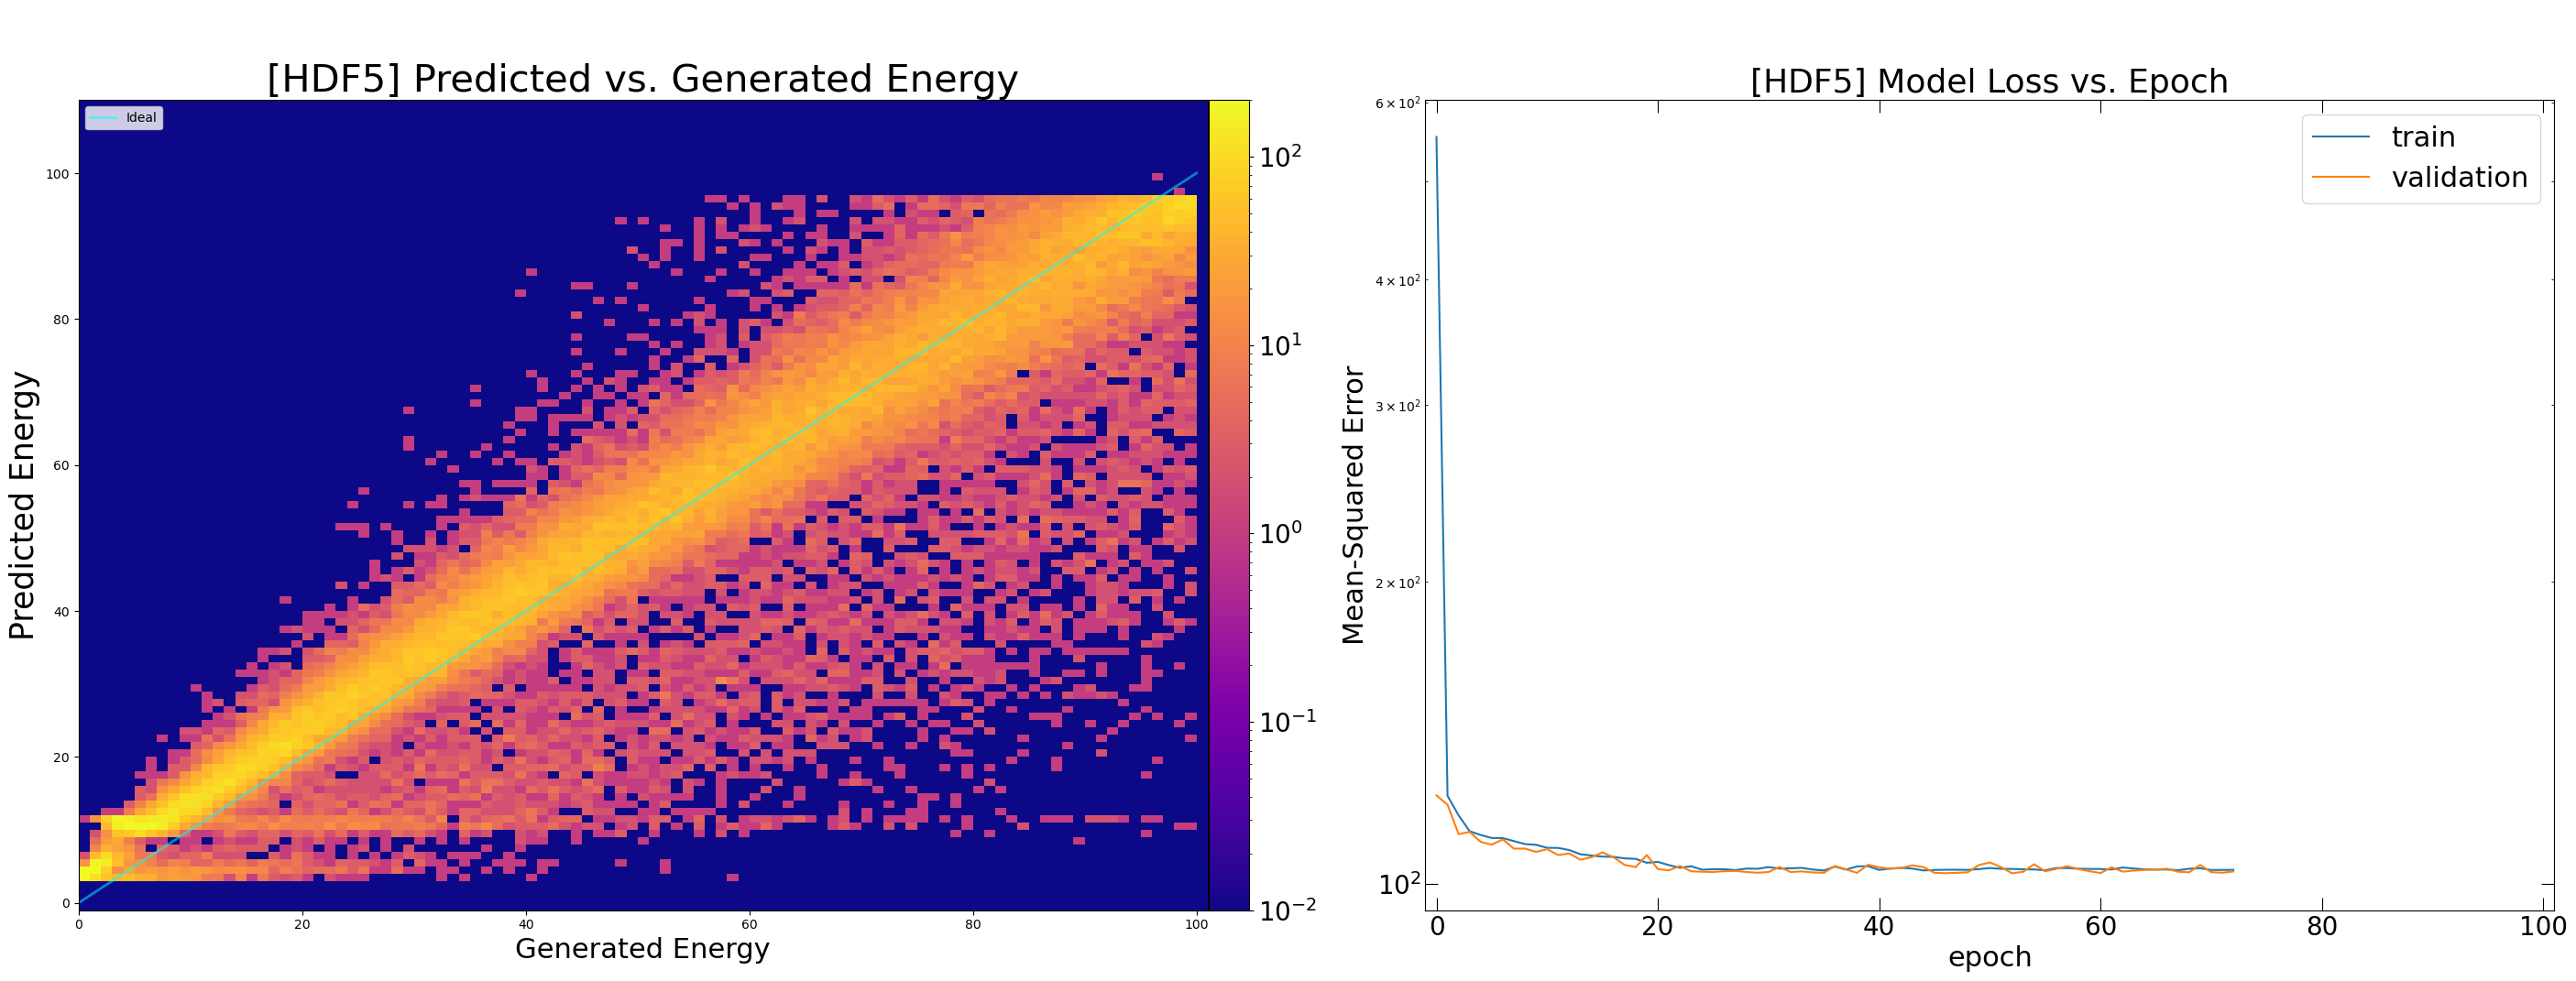

In [29]:
fig, axes = plt.subplots(1, 2,figsize=(28,10),constrained_layout=True)
#fig,axs = plt.subplots(int(N/10),10, figsize=(32, 16),sharex=False,sharey=True,constrained_layout=True)
axes = axes.ravel()
from copy import copy
from matplotlib.colors import LogNorm
#fig, axes = plt.subplots(nrows=1, figsize=(14, 10), constrained_layout=True)
cmap = copy(plt.cm.plasma)
cmap.set_bad(cmap(0))
edges=np.linspace(-10,110,121)
h, xedges, yedges = np.histogram2d(h5_Y_test,h5_preds[:,0], bins=[edges, edges])
#xedges=yedges
pcm = axes[0].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         norm=LogNorm(vmin=1.0e-2,vmax=2.0e2), rasterized=True)
cb = fig.colorbar(pcm, ax=axes[0], pad=0)
#cb.set_label("Counts",fontsize=22)
cb.ax.tick_params(labelsize=20)
axes[0].set_xlabel("Generated Energy",fontsize=22)
#axes[0].set_yticks(fontsize=20)
#axes[0].set_xticks(fontsize=20)
axes[0].set_ylim(-1,110)
axes[0].set_xlim(-0,101)
axes[0].plot([0, 100], [0, 100], color="cyan",linewidth=2,alpha=0.5,label="Ideal")
axes[0].legend(loc="upper left")
axes[0].set_ylabel("Predicted Energy",fontsize=25)
axes[0].set_title("[HDF5] Predicted vs. Generated Energy",fontsize=30)


axes[1].plot(h5_fit.history['loss'])
axes[1].plot(h5_fit.history['val_loss'])
axes[1].set_title('[HDF5] Model Loss vs. Epoch',fontsize=26)

fig.text(1.05,1.1,"  ",transform=axes[0].transAxes,fontsize=10)
axes[1].set_ylabel('Mean-Squared Error',fontsize=22)
axes[1].set_yscale('log')
axes[1].set_xlabel('epoch',fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.tick_params(direction='in',right=True,top=True,which='minor')
axes[1].set_xlim([-1,101])
axes[1].legend(['train', 'validation'], loc='upper right',fontsize=22)
plt.savefig("%s/H5_Correlation.png"%(output_path))

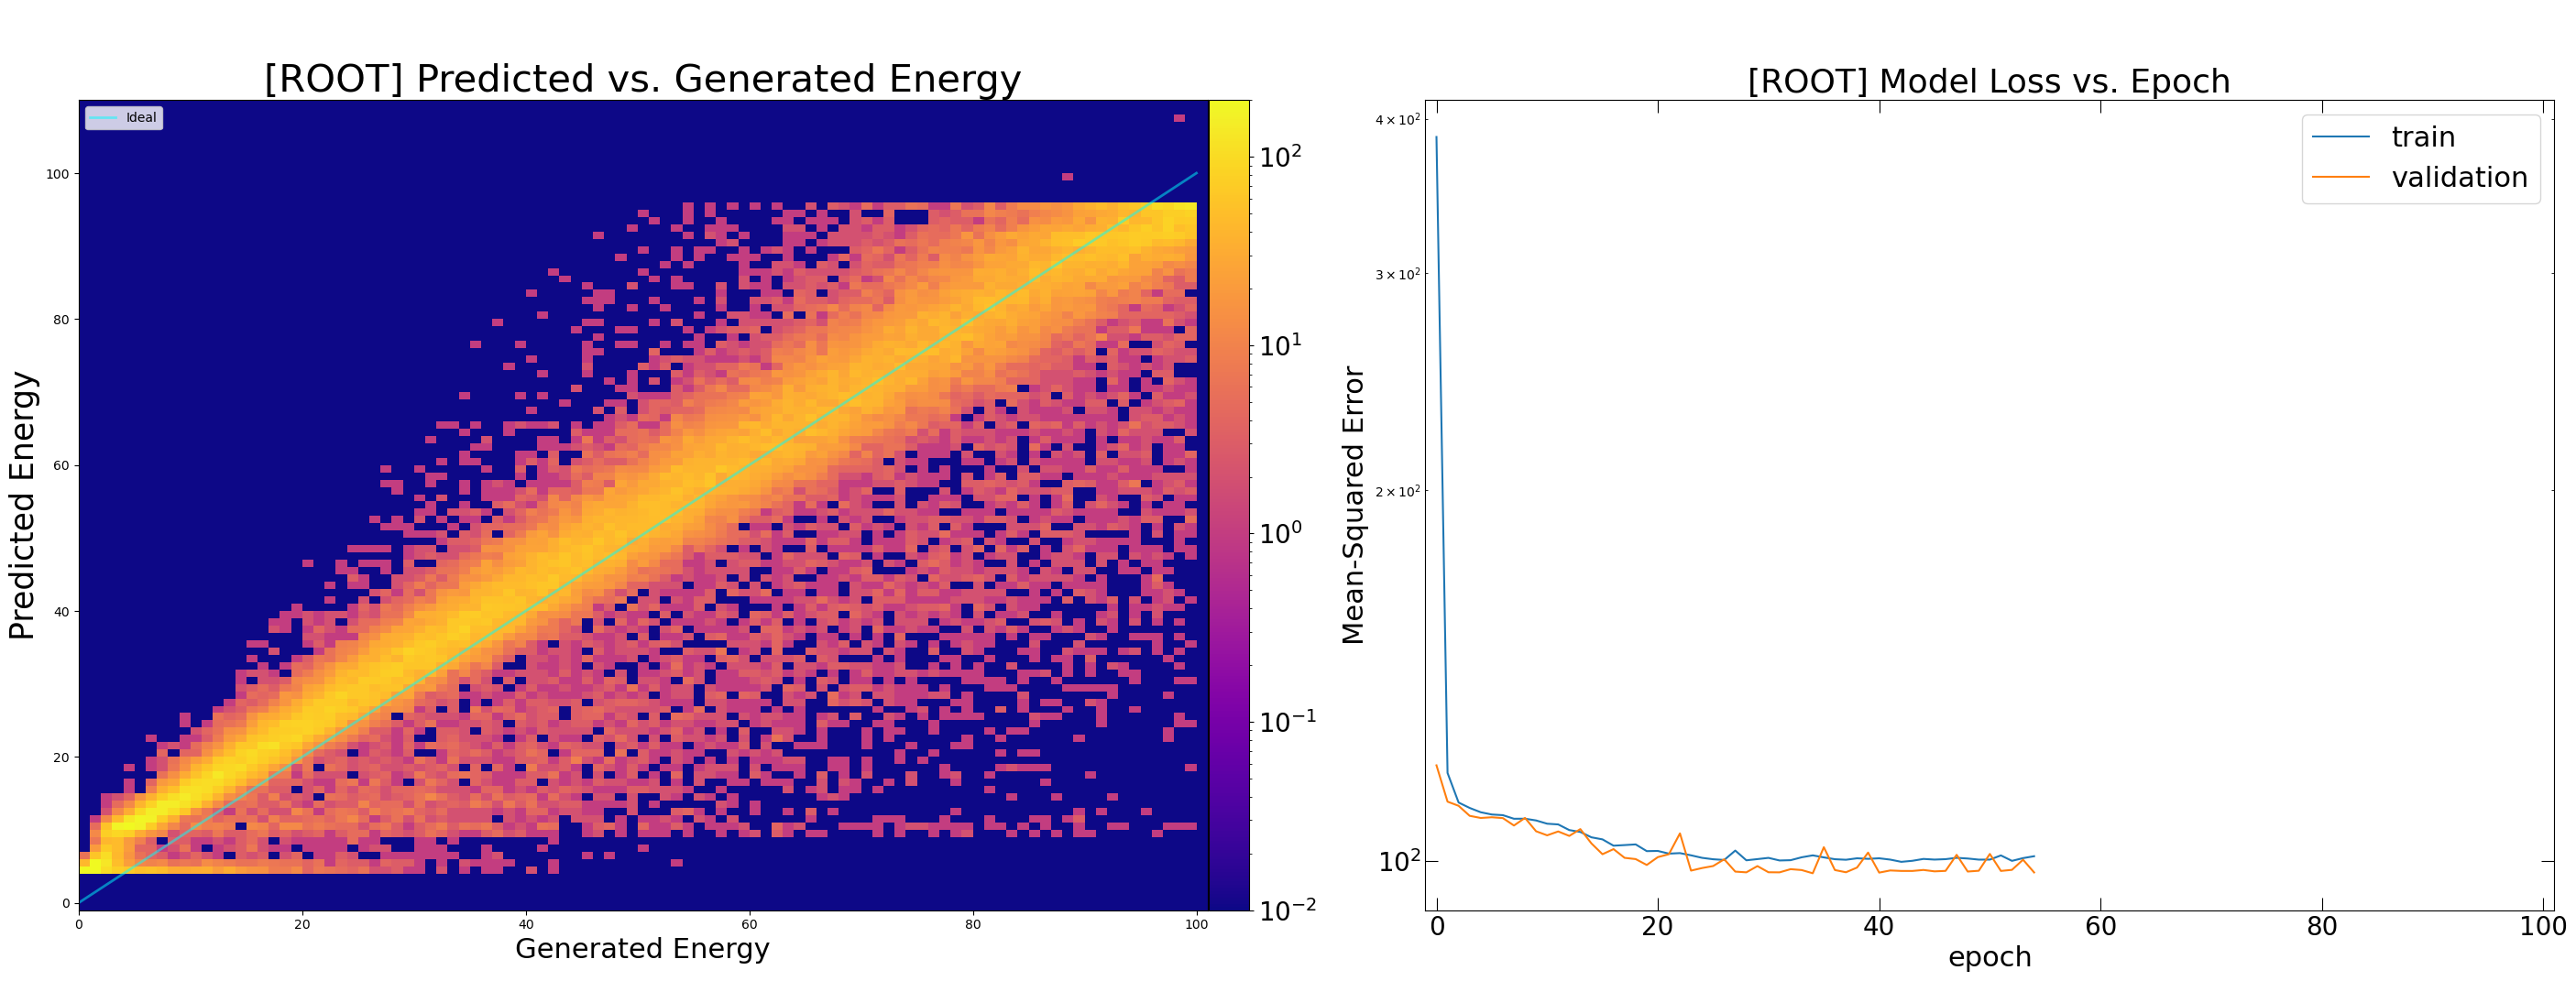

In [30]:
fig, axes = plt.subplots(1, 2,figsize=(28,10),constrained_layout=True)
axes = axes.ravel()
from copy import copy
from matplotlib.colors import LogNorm
cmap = copy(plt.cm.plasma)
cmap.set_bad(cmap(0))
edges=np.linspace(-10,110,121)
h, xedges, yedges = np.histogram2d(R_Y_test,R_preds[:,0], bins=[edges, edges])
pcm = axes[0].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         norm=LogNorm(vmin=1.0e-2,vmax=2.0e2), rasterized=True)
cb = fig.colorbar(pcm, ax=axes[0], pad=0)
cb.ax.tick_params(labelsize=20)
axes[0].set_xlabel("Generated Energy",fontsize=22)
axes[0].set_ylim(-1,110)
axes[0].set_xlim(-0,101)
axes[0].plot([0, 100], [0, 100], color="cyan",linewidth=2,alpha=0.5,label="Ideal")
axes[0].legend(loc="upper left")
axes[0].set_ylabel("Predicted Energy",fontsize=25)
axes[0].set_title("[ROOT] Predicted vs. Generated Energy",fontsize=30)


axes[1].plot(R_fit.history['loss'])
axes[1].plot(R_fit.history['val_loss'])
axes[1].set_title('[ROOT] Model Loss vs. Epoch',fontsize=26)

fig.text(1.05,1.1," ",transform=axes[0].transAxes,fontsize=10)
axes[1].set_ylabel('Mean-Squared Error',fontsize=22)
axes[1].set_yscale('log')
axes[1].set_xlabel('epoch',fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.tick_params(direction='in',right=True,top=True,which='minor')
axes[1].set_xlim([-1,101])
axes[1].legend(['train', 'validation'], loc='upper right',fontsize=22)
plt.savefig("%s/ROOT_Correlation.png"%(output_path))

In [31]:
star_energies = [12,16,20,25,30,50,60,70]
star_res = [0.18, 0.16, 0.15, 0.14, 0.13, 0.098, 0.092, 0.090]

ECCE_res = [0.15,0.127,0.117,0.121,0.106,0.102,0.092,0.098]
ECCE_energies = [10,20,30,40,50,60,80,100]

## Fit the slices from the DNN and extract energy scale and resolution

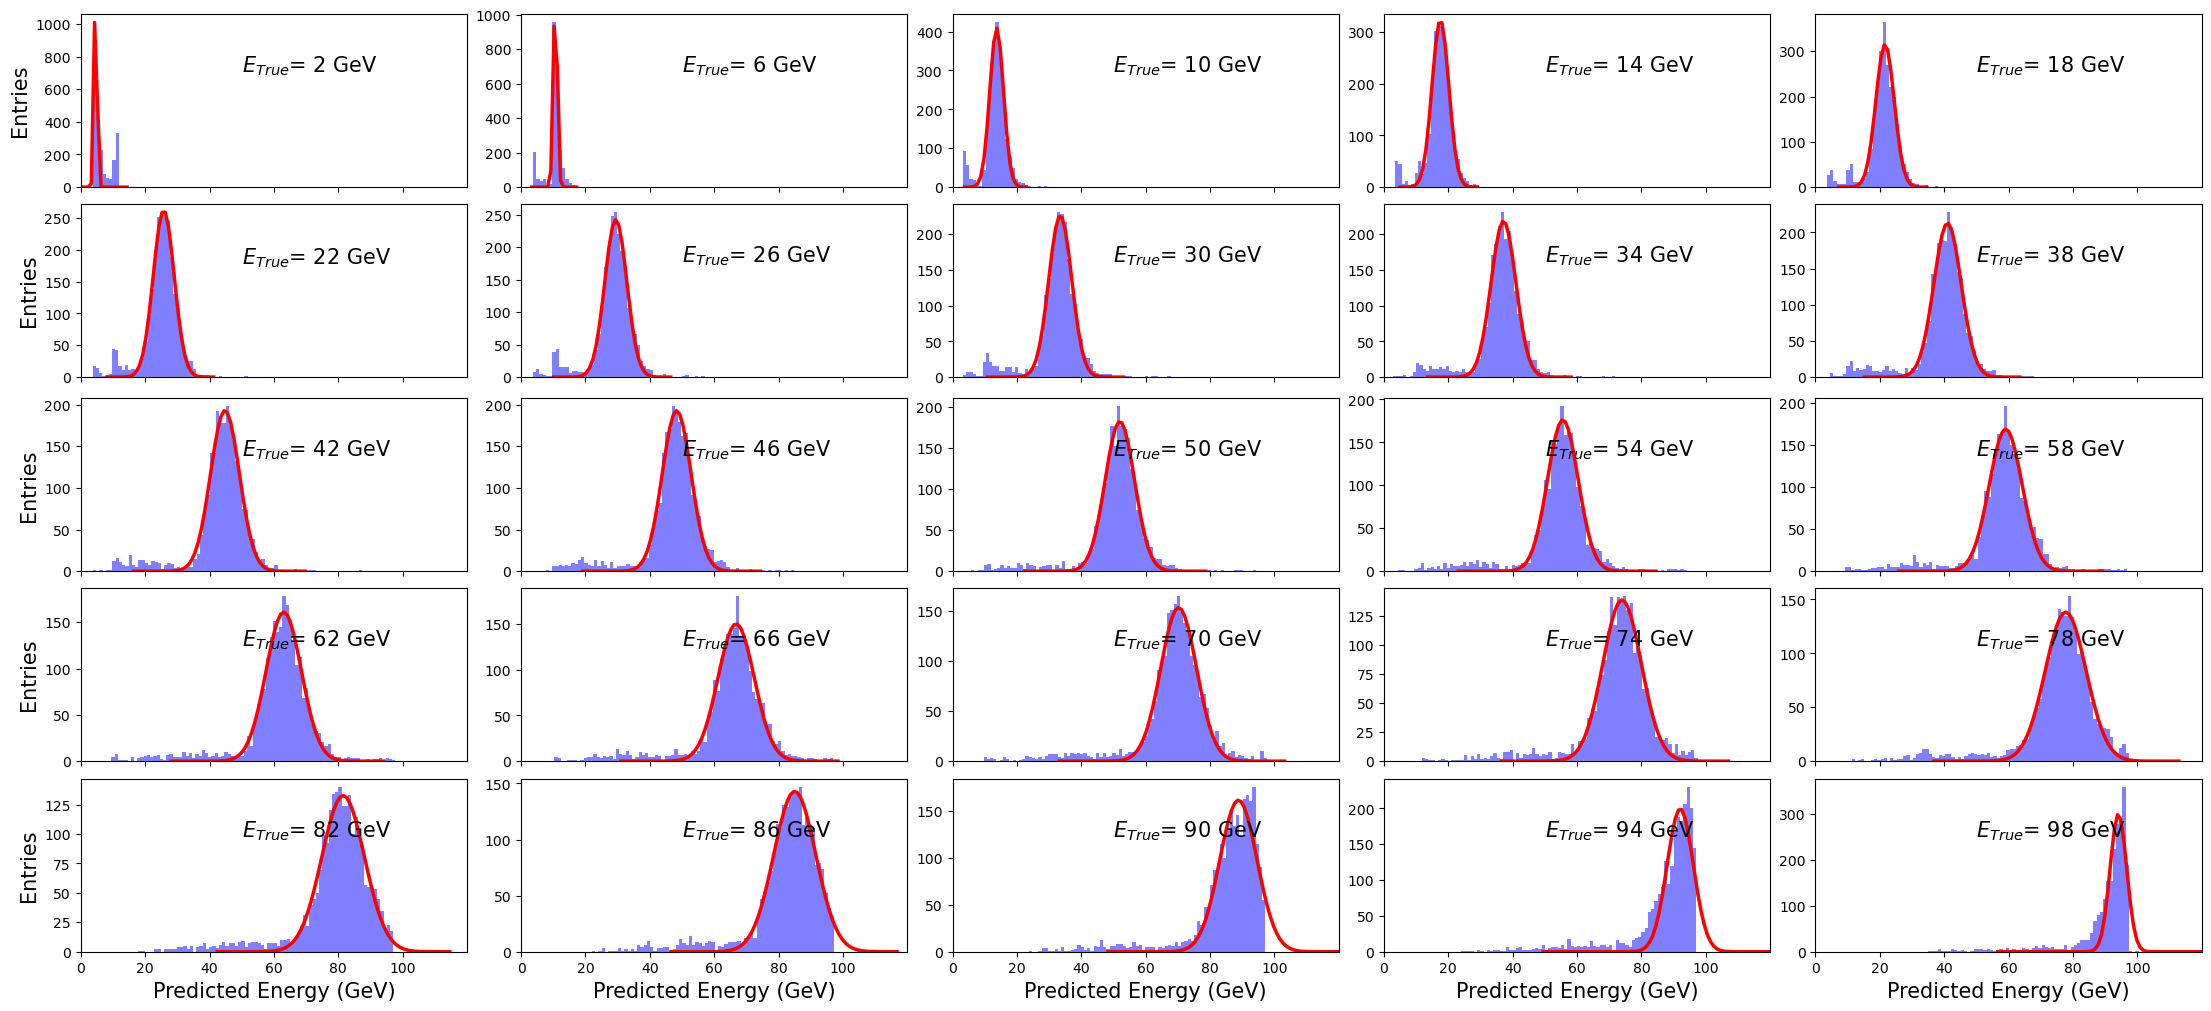

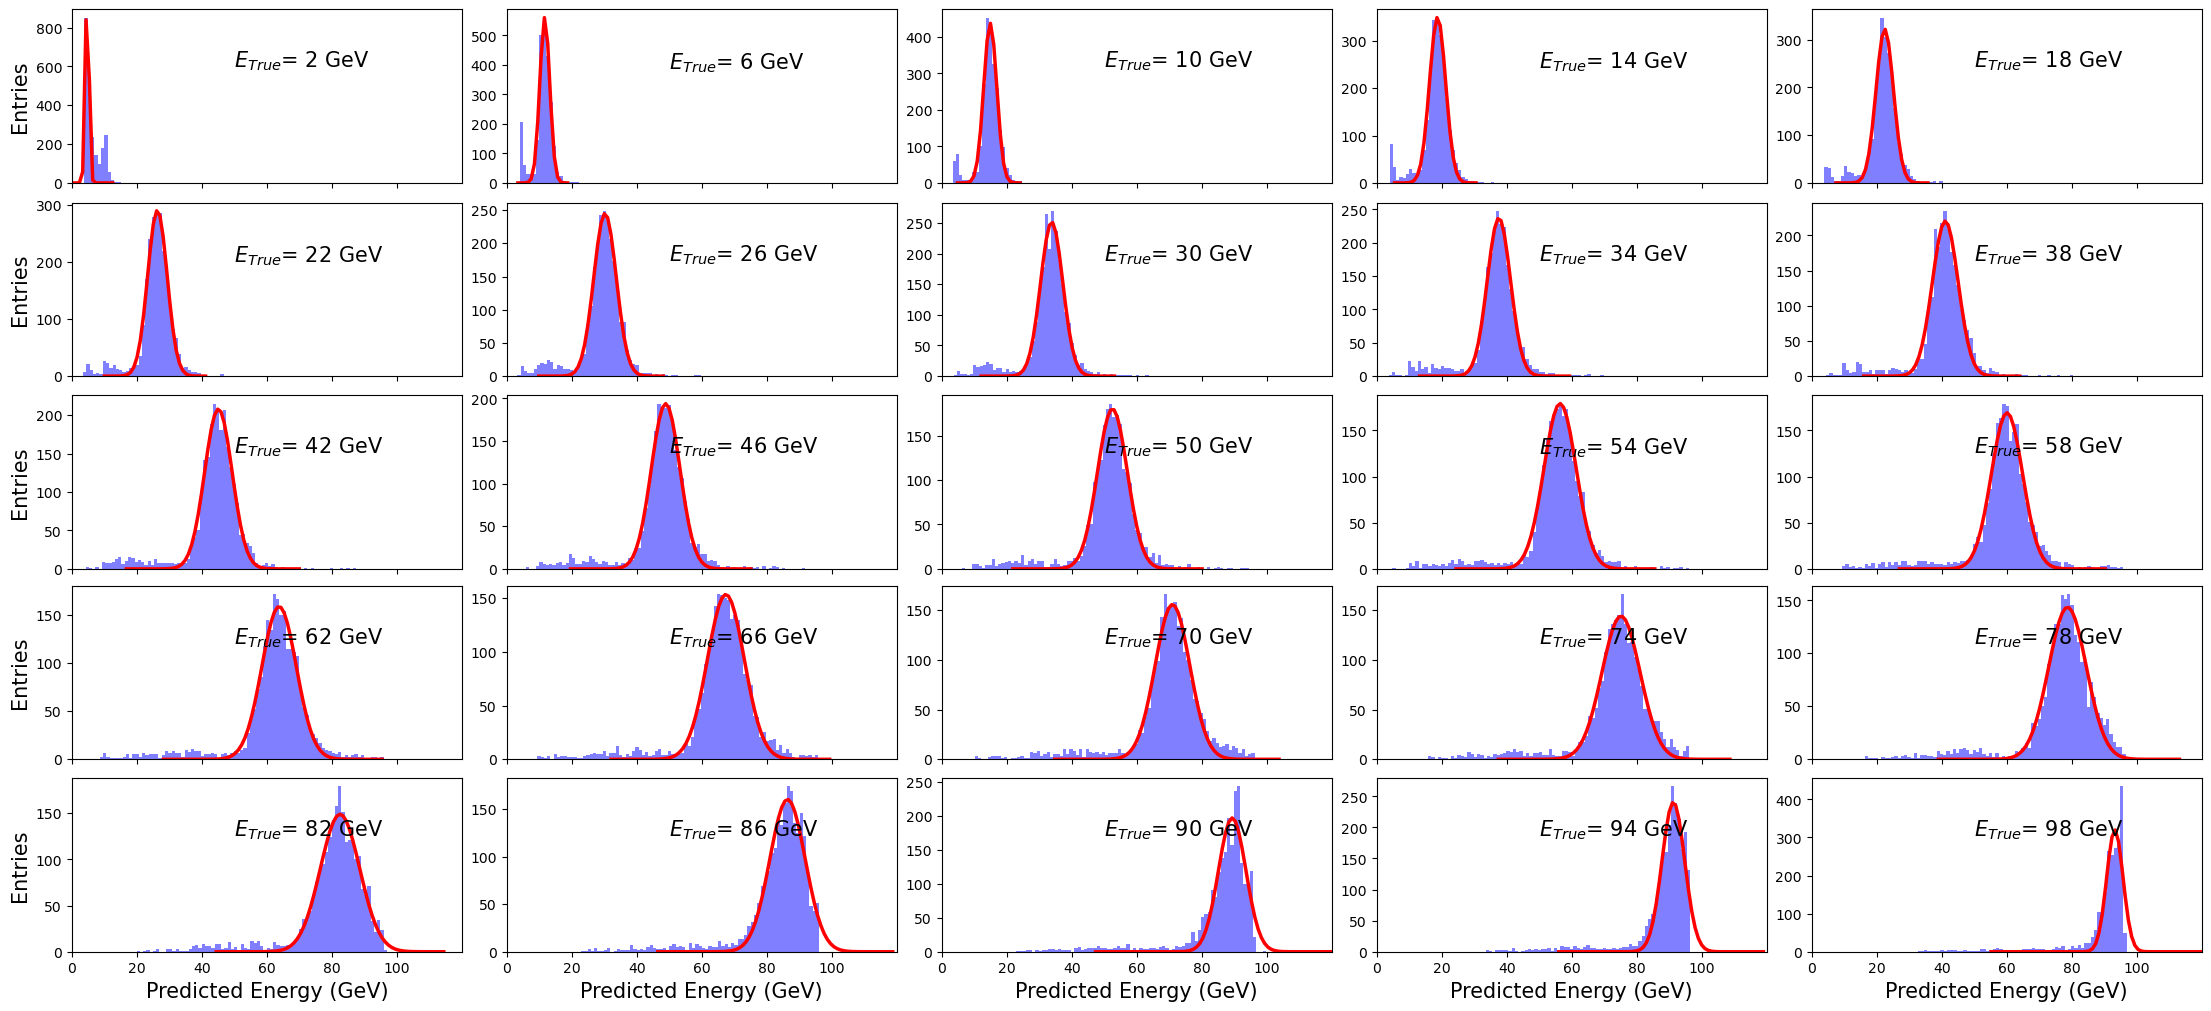

In [32]:
h5_resolution, h5_pred_over_truth, h5_avg_truth,h5_slices,h5_resolution_scale_corr = \
get_res_scale_fit(h5_Y_test,h5_preds,f"{output_path}/h5_dnn_slices.png")


R_resolution, R_pred_over_truth, R_avg_truth,R_slices, R_resolution_scale_corr = get_res_scale_fit(R_Y_test,\
                                        R_preds, f"{output_path}/Root_dnn_slices.png")



## Resolution and energy scale with strawman

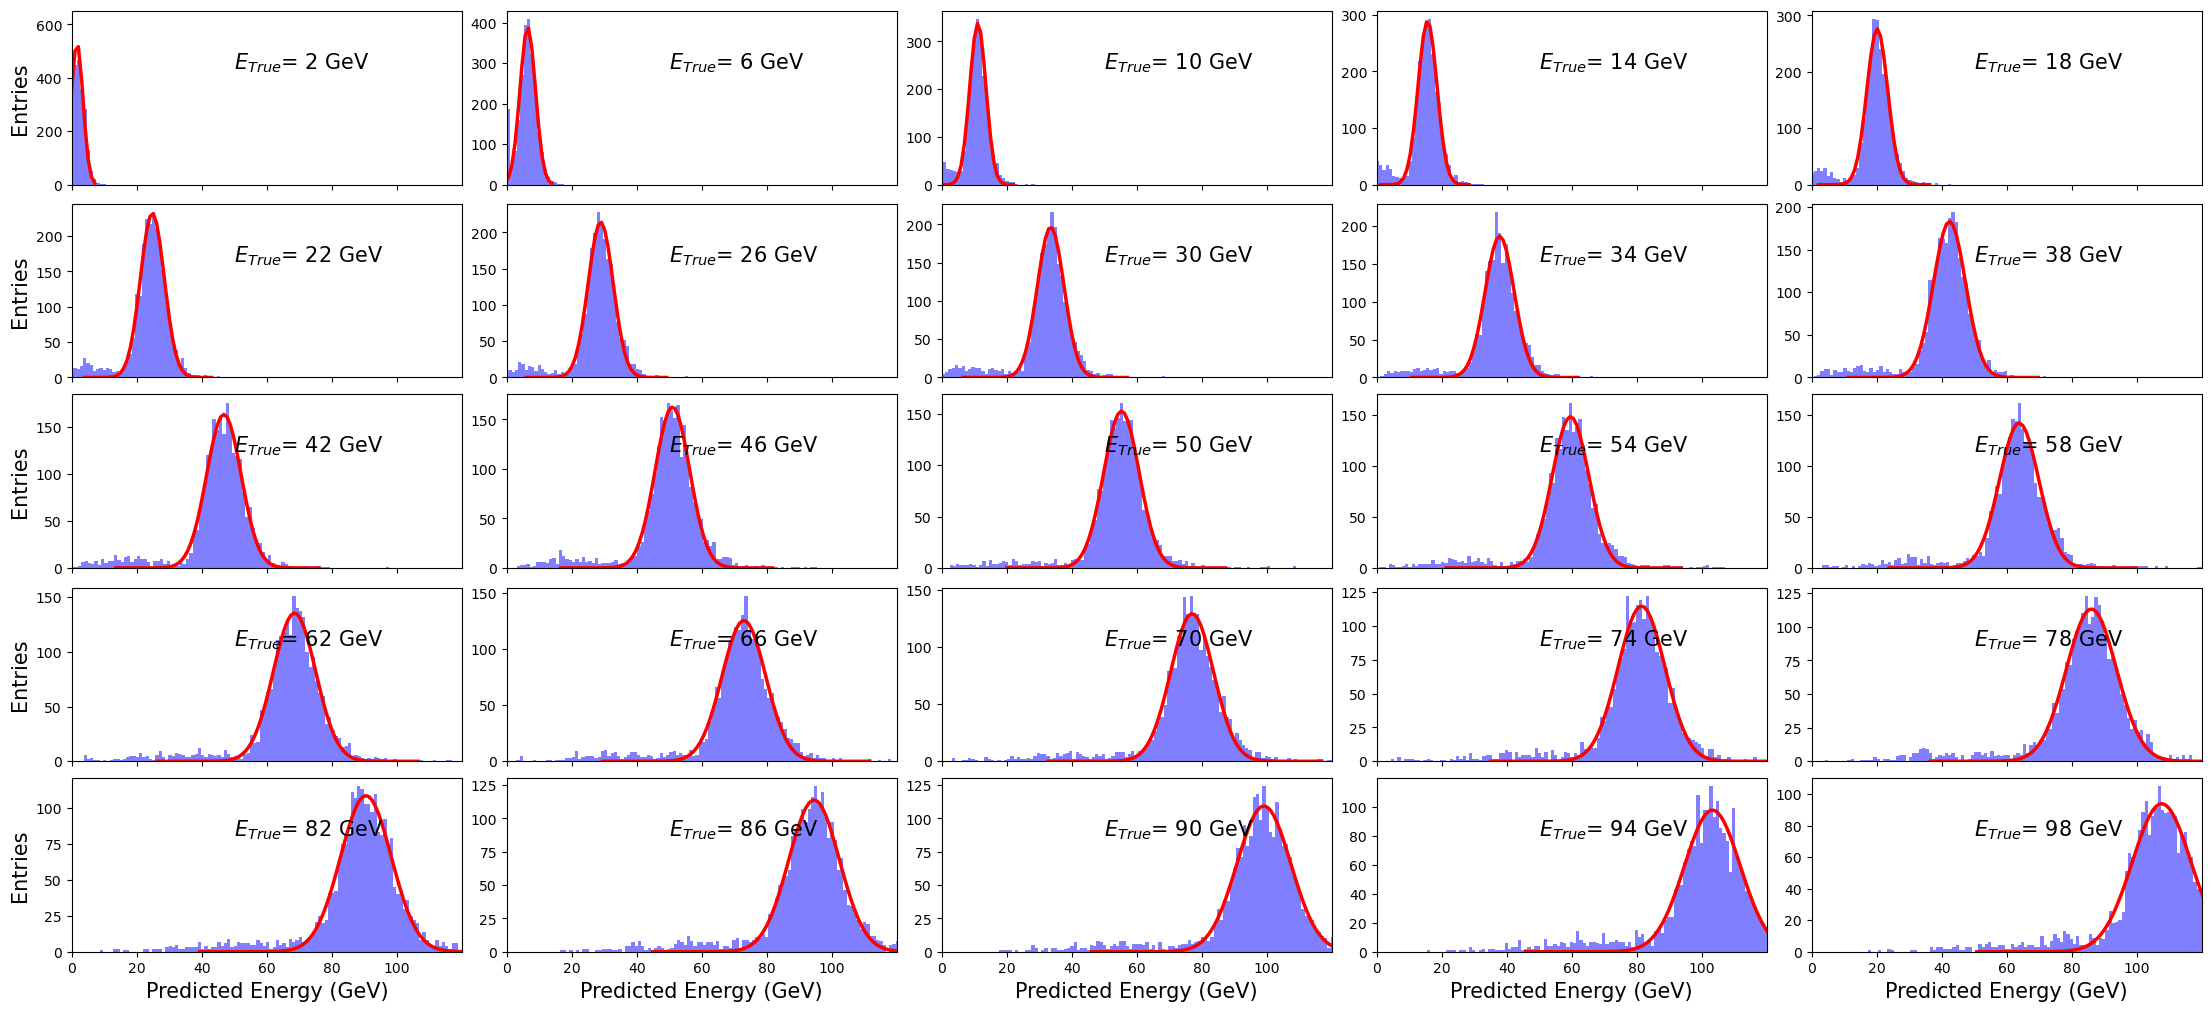

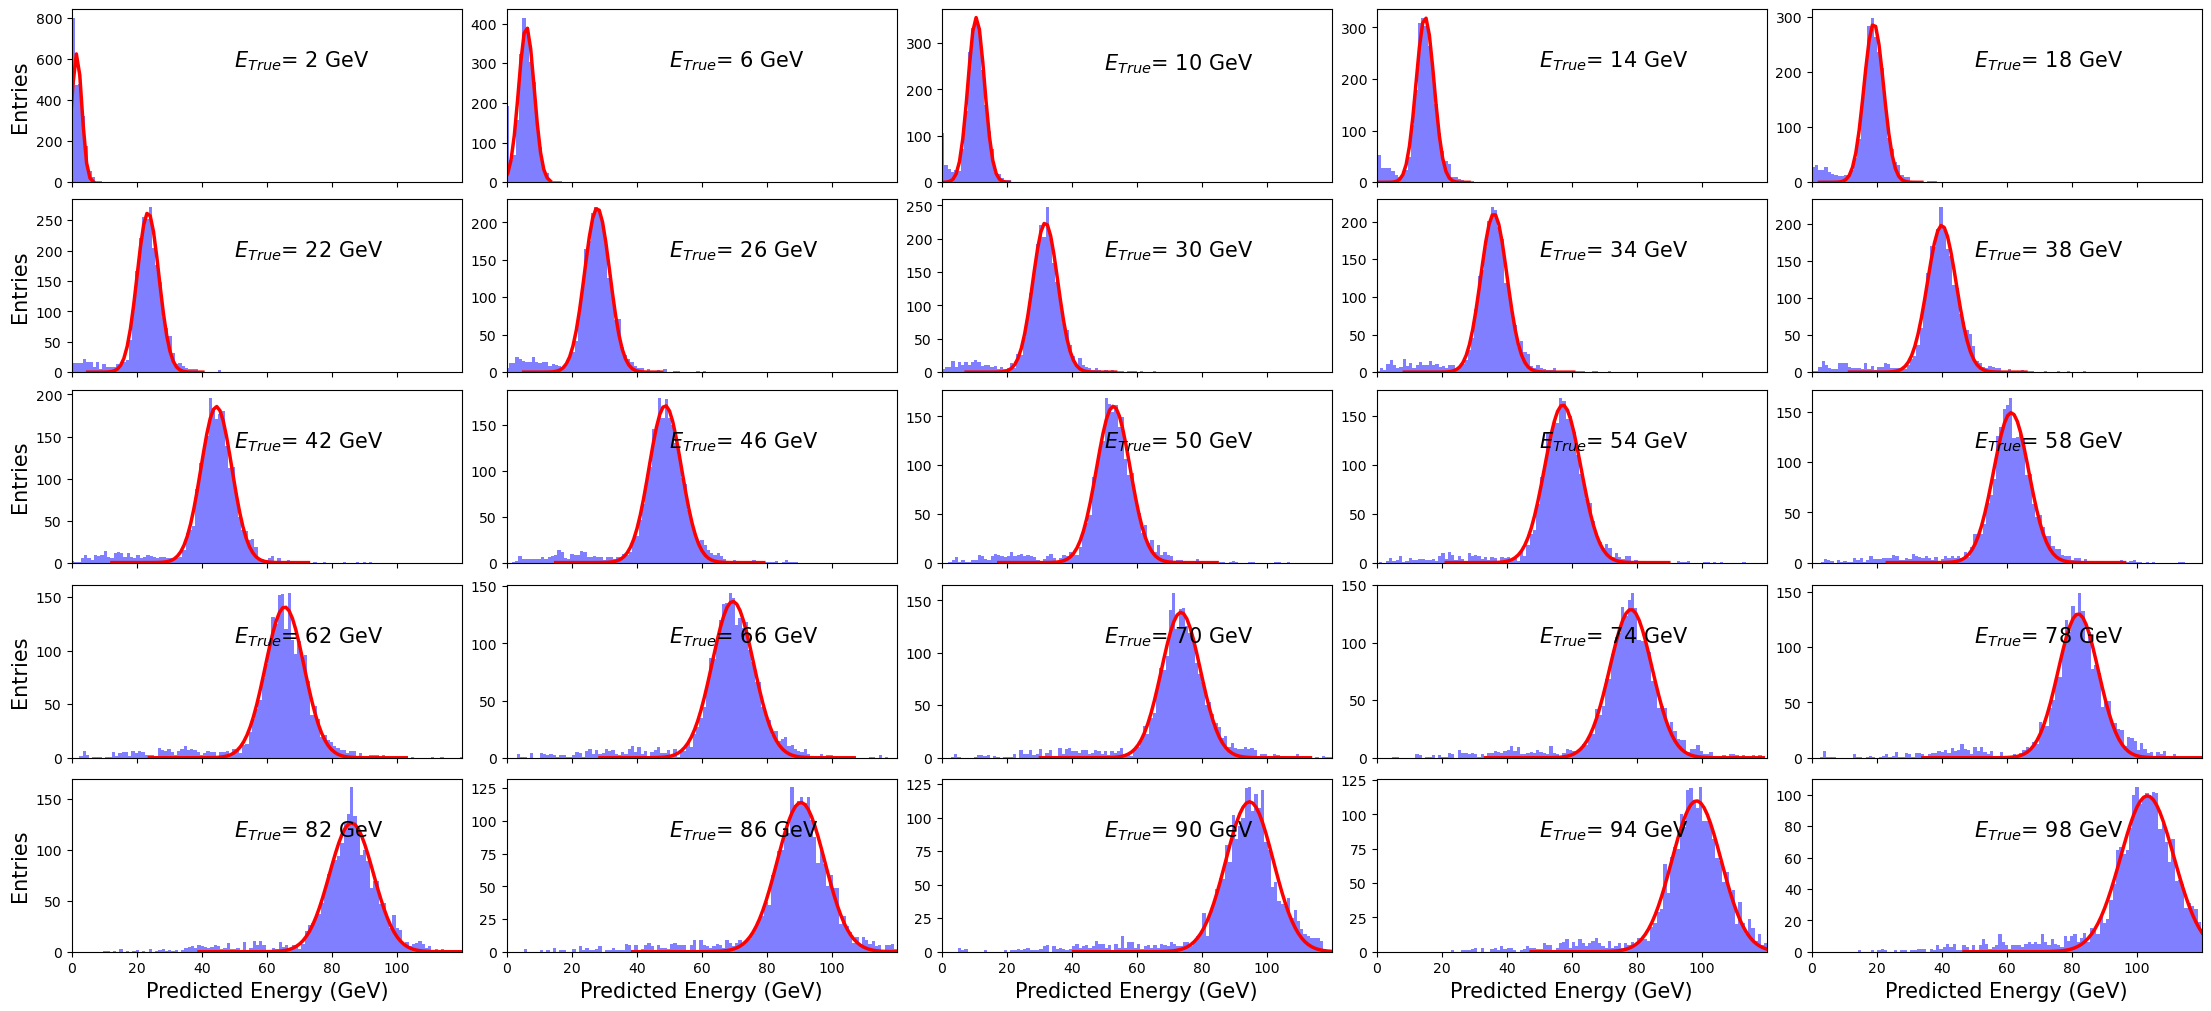

In [33]:
h5_straw_resolution, h5_straw_pred_over_truth, h5_straw_avg_truth,h5_straw_slices,h5_straw_resolution_scale_corr = \
get_res_scale_fit(h5_Y_test,h5_X_test,f"{output_path}/h5_strawman_slices.png")

## Using root files
R_straw_resolution, R_straw_pred_over_truth, R_straw_avg_truth,R_straw_slices, R_straw_resolution_scale_corr = \
get_res_scale_fit(R_Y_test, R_X_test, f"{output_path}/Root_strawman_slices.png")






In [34]:
print(h5_resolution)

[0.23693822833034084, 0.1038305756929205, 0.2119489217087431, 0.18676630816828357, 0.15850445889614334, 0.1480764145372992, 0.13136158118618013, 0.11863057130963926, 0.11328125511125699, 0.11188853793370358, 0.10679064223058164, 0.09748683555522698, 0.09142820676923877, 0.08824878510054872, 0.0883673707022325, 0.08834604473135807, 0.08556627935205947, 0.07951200160258452, 0.08057526520419317, 0.08156425295088521, 0.08077967326648551, 0.07585584766103642, 0.06429942024472893, 0.04341404088276783, 0.026266783396702728]


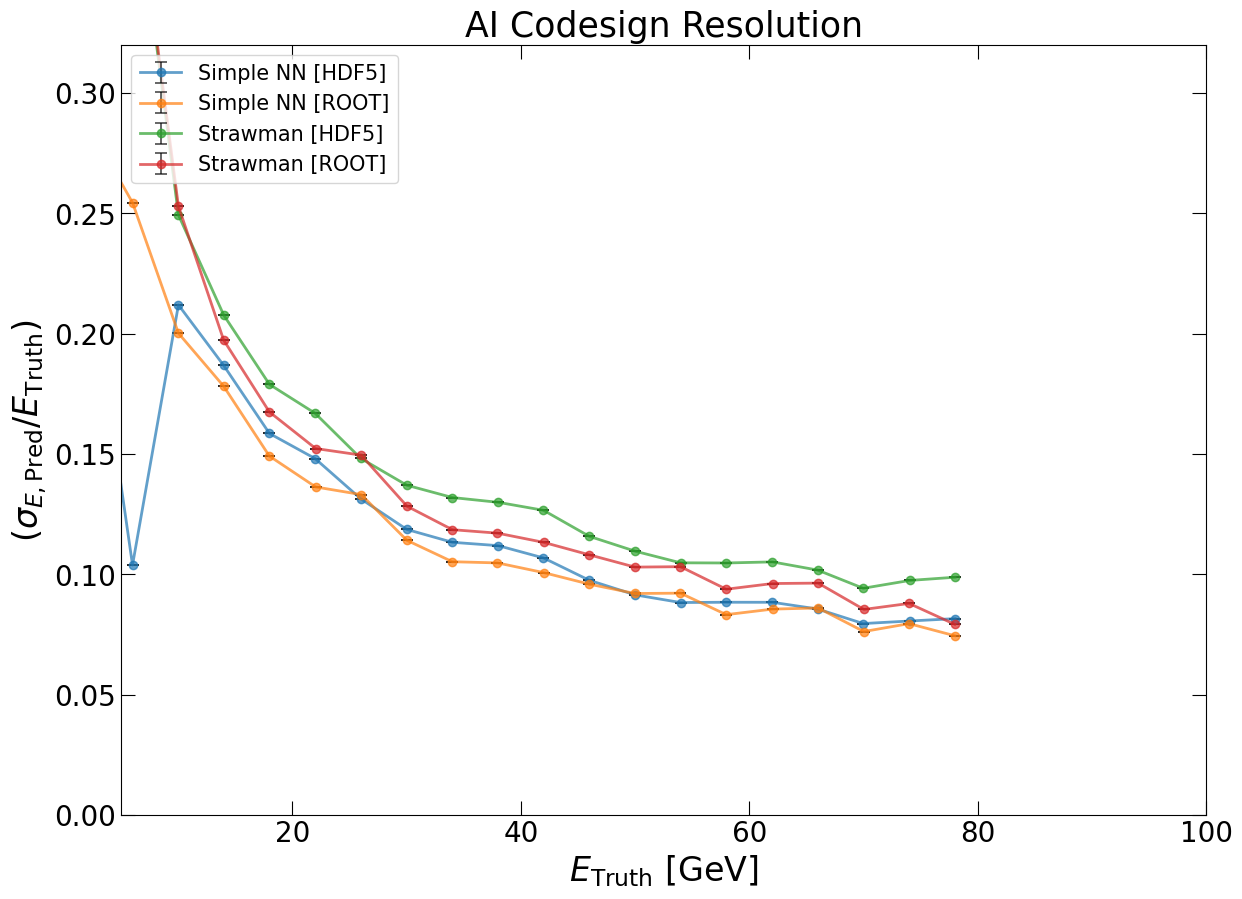

In [36]:
fig=plt.figure(figsize=(14,10))
plt.title("AI Codesign Resolution",fontsize=25)
plt.ylabel("$(\sigma_{E,\mathrm{Pred}}/E_\mathrm{Truth})$",fontsize=24)
plt.xlabel("$E_\mathrm{Truth}$ [GeV]",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
#plt.ylim(-0.02,0.4)
plt.ylim(0,2)
plt.ylim(0,.32)
plt.xlim(-0.01,100.01)
plt.xlim(5.0,100)
#errors = 1.0/(np.sqrt(2*counter-2))*stdev_pred
errors=np.zeros(len(h5_avg_truth))
ax = plt.subplot(1,1,1)
first_bin = 0
last_bin = 20

plt.text(0.8,-0.08," ",transform=ax.transAxes,fontsize=10)




plt.errorbar(h5_avg_truth[first_bin:last_bin],h5_resolution[first_bin:last_bin],errors[first_bin:last_bin],
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',marker="o",
             alpha=0.7,label="Simple NN [HDF5]")


plt.errorbar(R_avg_truth[first_bin:last_bin],R_resolution[first_bin:last_bin],errors[first_bin:last_bin],
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',marker="o"
             ,alpha=0.7,label="Simple NN [ROOT]")


plt.errorbar(h5_straw_avg_truth[first_bin:last_bin],h5_straw_resolution[first_bin:last_bin],errors[first_bin:last_bin],
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',marker="o",\
             alpha=0.7,label="Strawman [HDF5]")


plt.errorbar(R_straw_avg_truth[first_bin:last_bin],R_straw_resolution[first_bin:last_bin],errors[first_bin:last_bin],
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',marker="o",\
             alpha=0.7,label="Strawman [ROOT]")








#plt.plot(ECCE_energies,ECCE_res,"-o",label = "EIC Ref",color="limegreen")
#plt.plot(star_energies,star_res,"-o",label = "STAR",color="deeppink")
plt.legend(fontsize=15,loc="upper left")
plt.savefig("%s/h5_resolution_plot.pdf"%(output_path))





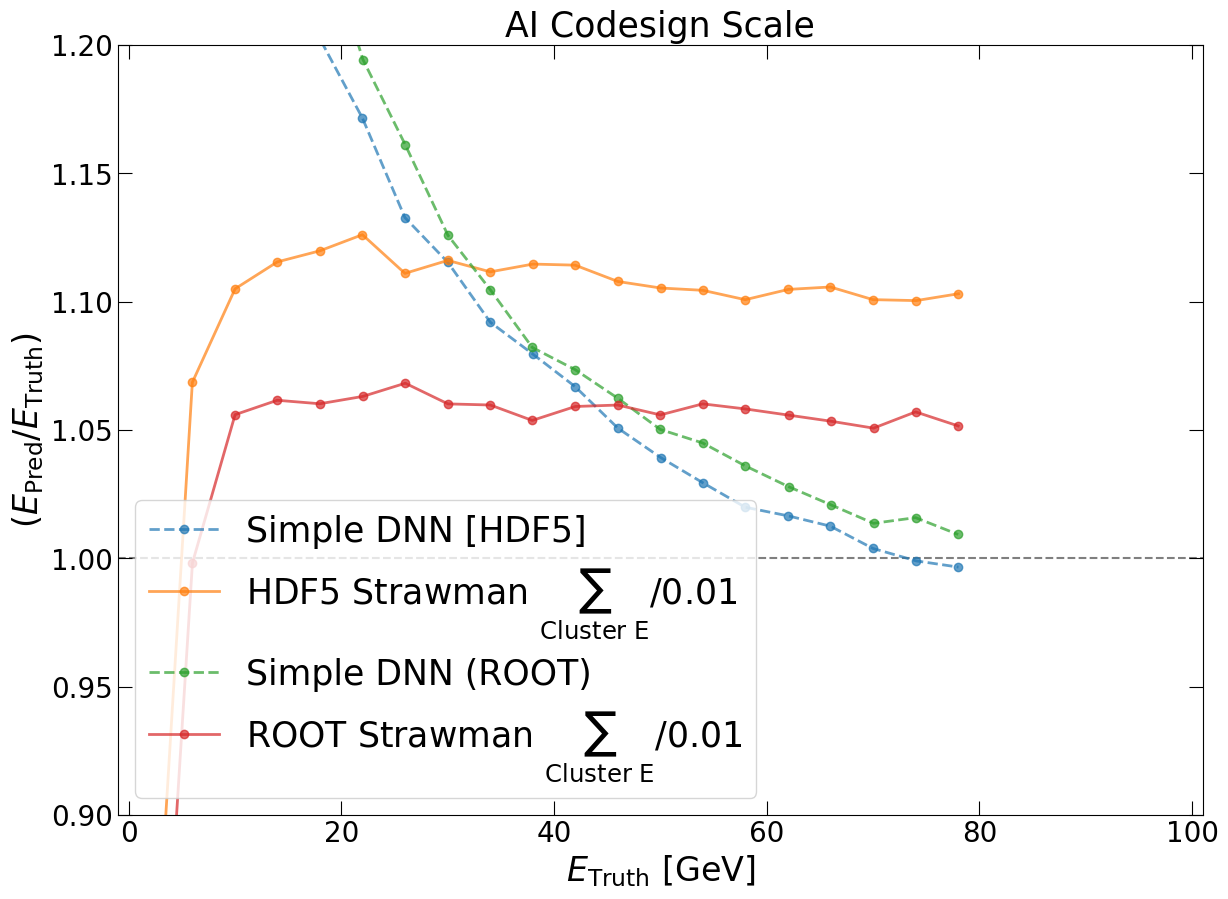

In [41]:
fig=plt.figure(figsize=(14,10))
plt.title("AI Codesign Scale",fontsize=25)
plt.ylabel("$(E_\mathrm{Pred}/E_\mathrm{Truth})$",fontsize=24)
plt.xlabel("$E_\mathrm{Truth}$ [GeV]",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.axhline(y=1.0, color='k', linestyle='--',alpha=0.5)#plt.ylim(-0.02,0.4)
plt.ylim(0.9,1.2)
plt.xlim(-1,101)
#errors = 1.0/(np.sqrt(2*counter-2))*stdev_pred
ax = plt.subplot(1,1,1)
first_bin = 0
last_bin = 20

string = "HDF5"
color1 = 'blue'
color2 = 'dodgerblue'



'''
h5_resolution, h5_pred_over_truth, h5_avg_truth,h5_slices,h5_resolution_scale_corr = 
R_resolution, R_pred_over_truth, R_avg_truth,R_slices, R_resolution_scale_corr = 
'''

#HDF5 NN   
plt.errorbar(h5_avg_truth[first_bin:last_bin],h5_pred_over_truth[first_bin:last_bin],#yerr=errors[first_bin:last_bin],
             linestyle="--",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,
             ecolor='black',marker="o",alpha=0.7,label="Simple DNN [HDF5]")

#Strawman
plt.errorbar(h5_straw_avg_truth[first_bin:last_bin],h5_straw_pred_over_truth[first_bin:last_bin],
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',
             marker="o",alpha=0.7,label="HDF5 Strawman $\sum_\mathrm{Cluster\ E} / %1.2f$"%(hcali_sampling_fraction))


#ROOT NN
plt.errorbar(R_avg_truth[first_bin:last_bin],R_pred_over_truth[first_bin:last_bin],#yerr=errors[first_bin:last_bin],
             linestyle="--",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,
             ecolor='black',marker="o",alpha=0.7,label="Simple DNN (ROOT)")


#ROOT Strawman

plt.errorbar(R_straw_avg_truth[first_bin:last_bin],R_straw_pred_over_truth[first_bin:last_bin],
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',
             marker="o",alpha=0.7,label="ROOT Strawman $\sum_\mathrm{Cluster\ E} /  $%1.2f"%(hcali_sampling_fraction))

#plt.text(0.7,0.7,"ROOT",transform=ax.transAxes,fontsize=25)

plt.legend(fontsize=25)
plt.text(0.8,-0.08," ",transform=ax.transAxes,fontsize=10)


plt.savefig("%s/%s_scale_plot.pdf"%(output_path,string))


## Using Arithematic mean

In [42]:
N_Bins = 20
E_Bins = np.linspace(0,100,N_Bins+1)

h5_resolution, h5_pred_over_truth, h5_avg_truth,h5_slices = get_res_scale(h5_Y_test,h5_preds)
h5_strawman_res, h5_strawman_scale, h5_avg_truth, h5_strawman_slices = get_res_scale(h5_Y_test,h5_X_test)

R_resolution, R_pred_over_truth, R_avg_truth,R_slices = get_res_scale(R_Y_test,R_preds)
R_strawman_res, R_strawman_scale, R_avg_truth,R_strawman_slices = get_res_scale(R_Y_test,R_X_test)

Text(0.65, -0.08, 'Reco = $\\sum_{E \\mathrm{cells}}$')

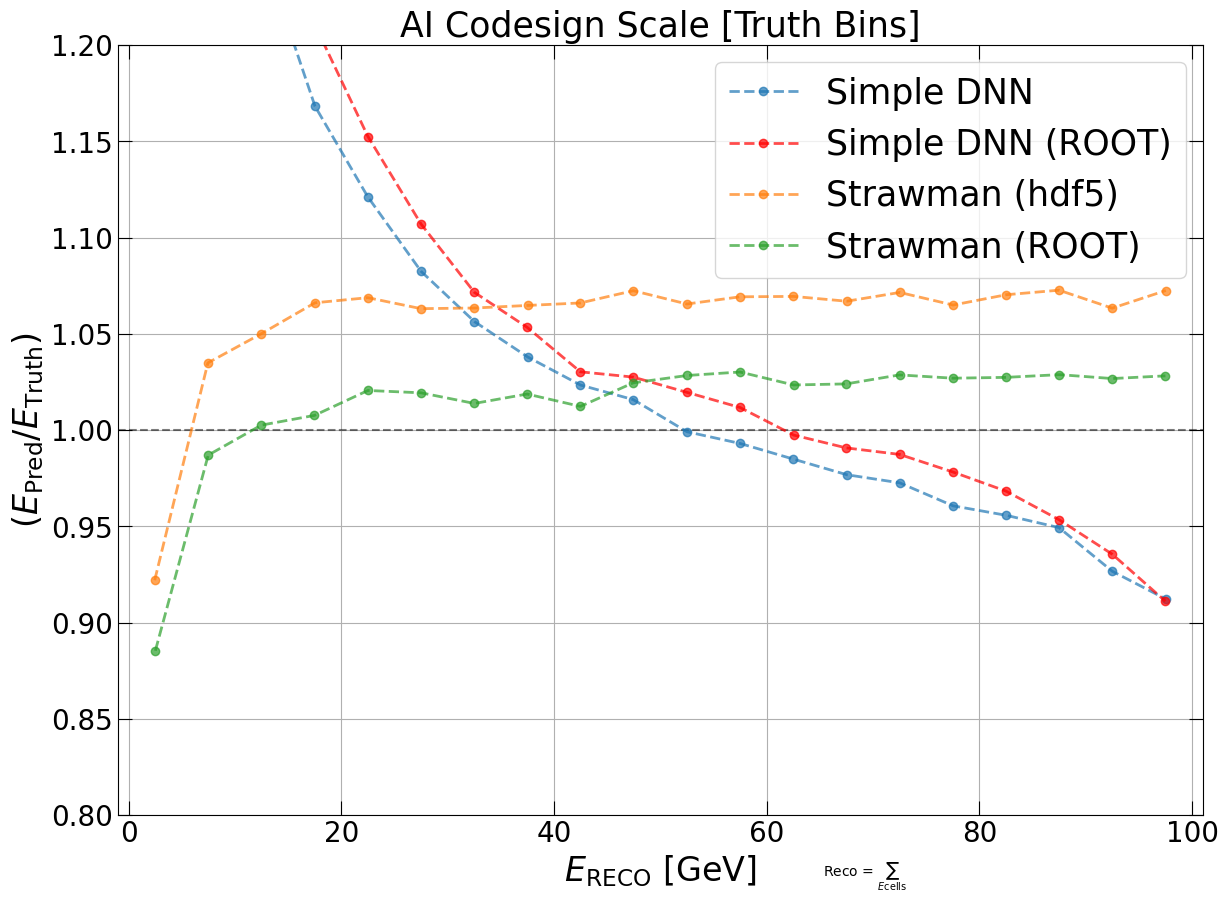

In [43]:
fig=plt.figure(figsize=(14,10))
plt.title("AI Codesign Scale [Truth Bins]",fontsize=25)
plt.ylabel("$(E_\mathrm{Pred}/E_\mathrm{Truth})$",fontsize=24)
plt.xlabel("$E_\mathrm{RECO}$ [GeV]",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.axhline(y=1.0, color='k', linestyle='--',alpha=0.5)#plt.ylim(-0.02,0.4)
plt.ylim(0.8,1.2)
plt.xlim(-1,101)
#errors = 1.0/(np.sqrt(2*counter-2))*stdev_pred
ax = plt.subplot(1,1,1)
first_bin = 0
last_bin = 20

string = "HDF5"
color1 = 'blue'
color2 = 'dodgerblue'
#HDF5 NN   
plt.errorbar(h5_avg_truth[first_bin:last_bin],h5_pred_over_truth[first_bin:last_bin],#yerr=errors[first_bin:last_bin],
             linestyle="--",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,
             ecolor='black',marker="o",alpha=0.7,label="Simple DNN")


#ROOT NN
plt.errorbar(R_avg_truth[first_bin:last_bin],R_pred_over_truth[first_bin:last_bin],#yerr=errors[first_bin:last_bin],
             linestyle="--",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,
             ecolor='black',marker="o",color='red',alpha=0.7,label="Simple DNN (ROOT)")


#HDF5 strawman  
plt.errorbar(h5_avg_truth[first_bin:last_bin],h5_strawman_scale[first_bin:last_bin],#yerr=errors[first_bin:last_bin],
             linestyle="--",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,
             ecolor='black',marker="o",alpha=0.7,label="Strawman (hdf5)")


#ROOT Strawman
plt.errorbar(R_avg_truth[first_bin:last_bin],R_strawman_scale[first_bin:last_bin],#yerr=errors[first_bin:last_bin],
             linestyle="--",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,
             ecolor='black',marker="o",alpha=0.7,label="Strawman (ROOT)")

plt.grid(True)
#plt.text(0.7,0.7,"ROOT",transform=ax.transAxes,fontsize=25)

plt.legend(fontsize=25)
#plt.text(0.8,-0.08,label,transform=ax.transAxes,fontsize=10)

plt.text(0.65,-0.08,"Reco = $\sum_{E \mathrm{cells}}$",transform=ax.transAxes,fontsize=10)


In [ ]:
# 48-52 GeV Slice
#look at the distribution of the PRED in that slice
#
#h5_Y_test,h5_preds

mask = (h5_Y_test < 55.)
mask = np.logical_and(mask,h5_Y_test > 50.)

#h5_X_test = Strawman [HDF5]pre
plt.hist(h5_X_test[mask],bins=50, label="Function Slicing",alpha=0.5)
plt.hist(h5_strawman_slices[10],bins=50,label="Direct Slicing",alpha=0.5)
#plt.hist(h5_strawman_slices[9],bins=50,label="Direct Slicing -1 Bin",alpha=0.5)
#plt.hist(h5_strawman_slices[11],bins=50,label="Direct Slicing +1 Bin",alpha=0.5)
plt.legend()


In [ ]:
fig,axs = plt.subplots(int(N_Bins/10),10, figsize=(32, 10),sharex=False,sharey=True,constrained_layout=True)
for i in range(N_Bins):
    row = int(i/10)
    col = i%10
    if(row==int(N_Bins/10)): continue
    ax = axs[row,col]
    
    if (col==0):
        ax.set_ylabel("Counts",fontsize=15)
    if (np.all(np.isnan(h5_slices[i]))): continue
    temp_bin = np.linspace(h5_avg_truth[i]-2.0,h5_avg_truth[i]+2.0,16)
    ax.set_title("%1.1f $ < E_\mathrm{Truth} < $%1.1f [GeV]"%(E_Bins[i],E_Bins[i+1]),fontsize=10)
    ax.set_xlabel("Predicted Eenergy")
    ax.hist(h5_slices[i],label="Predicted Energies",bins=20)
    ax.axvline(x=h5_avg_truth[i],color='red',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Truth} = %1.2f$"%(h5_avg_truth[i]))
    ax.axvline(x=np.nanmean(h5_slices,axis=-1)[i],color='cyan',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Pred} = %1.2f$"%(np.nanmean(h5_slices,axis=-1)[i]))

    ax.legend(fontsize=7.5)
    ax.tick_params(direction='in',right=True,top=True,length=5)
plt.savefig("%s/h5_resolutions_slices.pdf"%(path))

In [ ]:
fig,axs = plt.subplots(int(N_Bins/10),10, figsize=(32, 10),sharex=False,sharey=True,constrained_layout=True)
for i in range(N_Bins):
    row = int(i/10)
    col = i%10
    if(row==int(N_Bins/10)): continue
    ax = axs[row,col]
    
    if (col==0):
        ax.set_ylabel("Counts",fontsize=15)

    if (np.all(np.isnan(R_slices[i]))): continue
    temp_bin = np.linspace(R_avg_truth[i]-2.0,R_avg_truth[i]+2.0,16)
    ax.set_title("%1.1f $ < E_\mathrm{Truth} < $%1.1f [GeV]"%(E_Bins[i],E_Bins[i+1]),fontsize=10)
    ax.set_xlabel("Predicted Eenergy")
    ax.hist(R_slices[i],label="Predicted Energies",bins=30)
    ax.axvline(x=R_avg_truth[i],color='red',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Truth} = %1.2f$"%(R_avg_truth[i]))
    ax.axvline(x=np.nanmean(R_slices,axis=-1)[i],color='cyan',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Pred} = %1.2f$"%(np.nanmean(h5_slices,axis=-1)[i]))

    ax.legend(fontsize=7.5)
    ax.tick_params(direction='in',right=True,top=True,length=5)
plt.savefig("%s/R_resolutions_slices.pdf"%(path))

In [ ]:
fig,axs = plt.subplots(int(N_Bins/10),10, figsize=(32, 10),sharex=False,sharey=True,constrained_layout=True)
for i in range(N_Bins):
    row = int(i/10)
    col = i%10
    if(row==int(N_Bins/10)): continue
    ax = axs[row,col]
    
    if (col==0):
        ax.set_ylabel("Counts",fontsize=15)
    if (np.all(np.isnan(h5_strawman_slices[i]))): continue
    temp_bin = np.linspace(h5_avg_truth[i]-2.0,h5_avg_truth[i]+2.0,16)
    ax.set_title("%1.1f $ < E_\mathrm{Truth} < $%1.1f [GeV]"%(E_Bins[i],E_Bins[i+1]),fontsize=10)
    ax.set_xlabel("Predicted Eenergy")
    ax.hist(h5_slices[i],label="Predicted Energies",bins=30)
    ax.axvline(x=h5_avg_truth[i],color='red',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Truth} = %1.2f$"%(h5_avg_truth[i]))
    ax.axvline(x=np.nanmean(h5_strawman_slices,axis=-1)[i],color='cyan',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Pred} = %1.2f$"%(np.nanmean(h5_strawman_slices,axis=-1)[i]))

    ax.legend(fontsize=7.5)
    ax.tick_params(direction='in',right=True,top=True,length=5)
plt.savefig("%s/h5_strawman_resolutions_slices.pdf"%(path))

#h5_strawman_res, h5_strawman_scale, h5_avg_truth, h5_strawman_slices

# Let's see what the scale and resolution look like in Bins of Reco (Input) Energy

In [ ]:
reco_h5_resolution, reco_h5_pred_over_truth, reco_h5_avg_reco, reco_h5_avg_truth, reco_h5_slices = get_res_scale_in_reco_bins(h5_Y_test,h5_preds,h5_X_test,22,0,100)
#reco_h5_strawman_res, reco_h5_strawman_scale, reco_h5_avg_truth, reco_h5_strawman_slices = get_res_scale(h5_Y_test,h5_X_test)

reco_R_resolution, reco_R_pred_over_truth, reco_R_avg_reco, reco_R_avg_truth, reco_R_slices = get_res_scale_in_reco_bins(R_Y_test,R_preds,R_X_test,22,0,100)
#R_strawman_res, R_strawman_scale, R_avg_truth,R_strawman_slices = get_res_scale(R_Y_test,R_X_test)

In [ ]:
fig=plt.figure(figsize=(14,10))
plt.title("AI Codesign Scale [Reco Bins]",fontsize=25)
plt.ylabel("$(E_\mathrm{Pred}/E_\mathrm{Truth})$",fontsize=24)
plt.xlabel("$E_\mathrm{RECO}$ [GeV]",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.axhline(y=1.0, color='k', linestyle='--',alpha=0.5)#plt.ylim(-0.02,0.4)
plt.ylim(0.8,1.1)
plt.xlim(-1,101)
#errors = 1.0/(np.sqrt(2*counter-2))*stdev_pred
ax = plt.subplot(1,1,1)
first_bin = 0
last_bin = N_Bins

string = "HDF5"
color1 = 'blue'
color2 = 'dodgerblue'
#HDF5 NN   
plt.errorbar(reco_h5_avg_reco[first_bin:last_bin],reco_h5_pred_over_truth[first_bin:last_bin],#yerr=errors[first_bin:last_bin],
             linestyle="--",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,
             ecolor='black',marker="o",color=color1,alpha=0.7,label="Simple DNN")


#ROOT NN
plt.errorbar(reco_R_avg_reco[first_bin:last_bin],reco_R_pred_over_truth[first_bin:last_bin],#yerr=errors[first_bin:last_bin],
             linestyle="--",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,
             ecolor='black',marker="o",color='red',alpha=0.7,label="Simple DNN (ROOT)")


#plt.text(0.7,0.7,"ROOT",transform=ax.transAxes,fontsize=25)

plt.legend(fontsize=25)
#plt.text(0.8,-0.08,label,transform=ax.transAxes,fontsize=10)

plt.text(0.65,-0.08,"Reco = $\sum_{E \mathrm{cells}}$",transform=ax.transAxes,fontsize=10)




plt.savefig("%s/Reco_Bins_%s_scale_plot.pdf"%(path,string))

If Normalization is desired